In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = ("#8E063B","#B9534C","#DA8459","#EEAB65","#F6C971","#F1DE81","#E2E6BD")[::-1]
events_cmap= ListedColormap(colors)

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).set_index('name')
# cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [3]:
df= pd.read_csv('merged_v0.46.csv', index_col='ID')

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,2,8,13,14,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
world['events']= df.groupby('COUNTRY').count()['DATE_BEGIN']

world['events']= world.apply(lambda x: len(gdf[gdf.COUNTRY==x.index]), axis=1)

In [19]:
world['events']= np.log10(world['events'])

In [20]:
world= world[~np.isinf(world.events)]

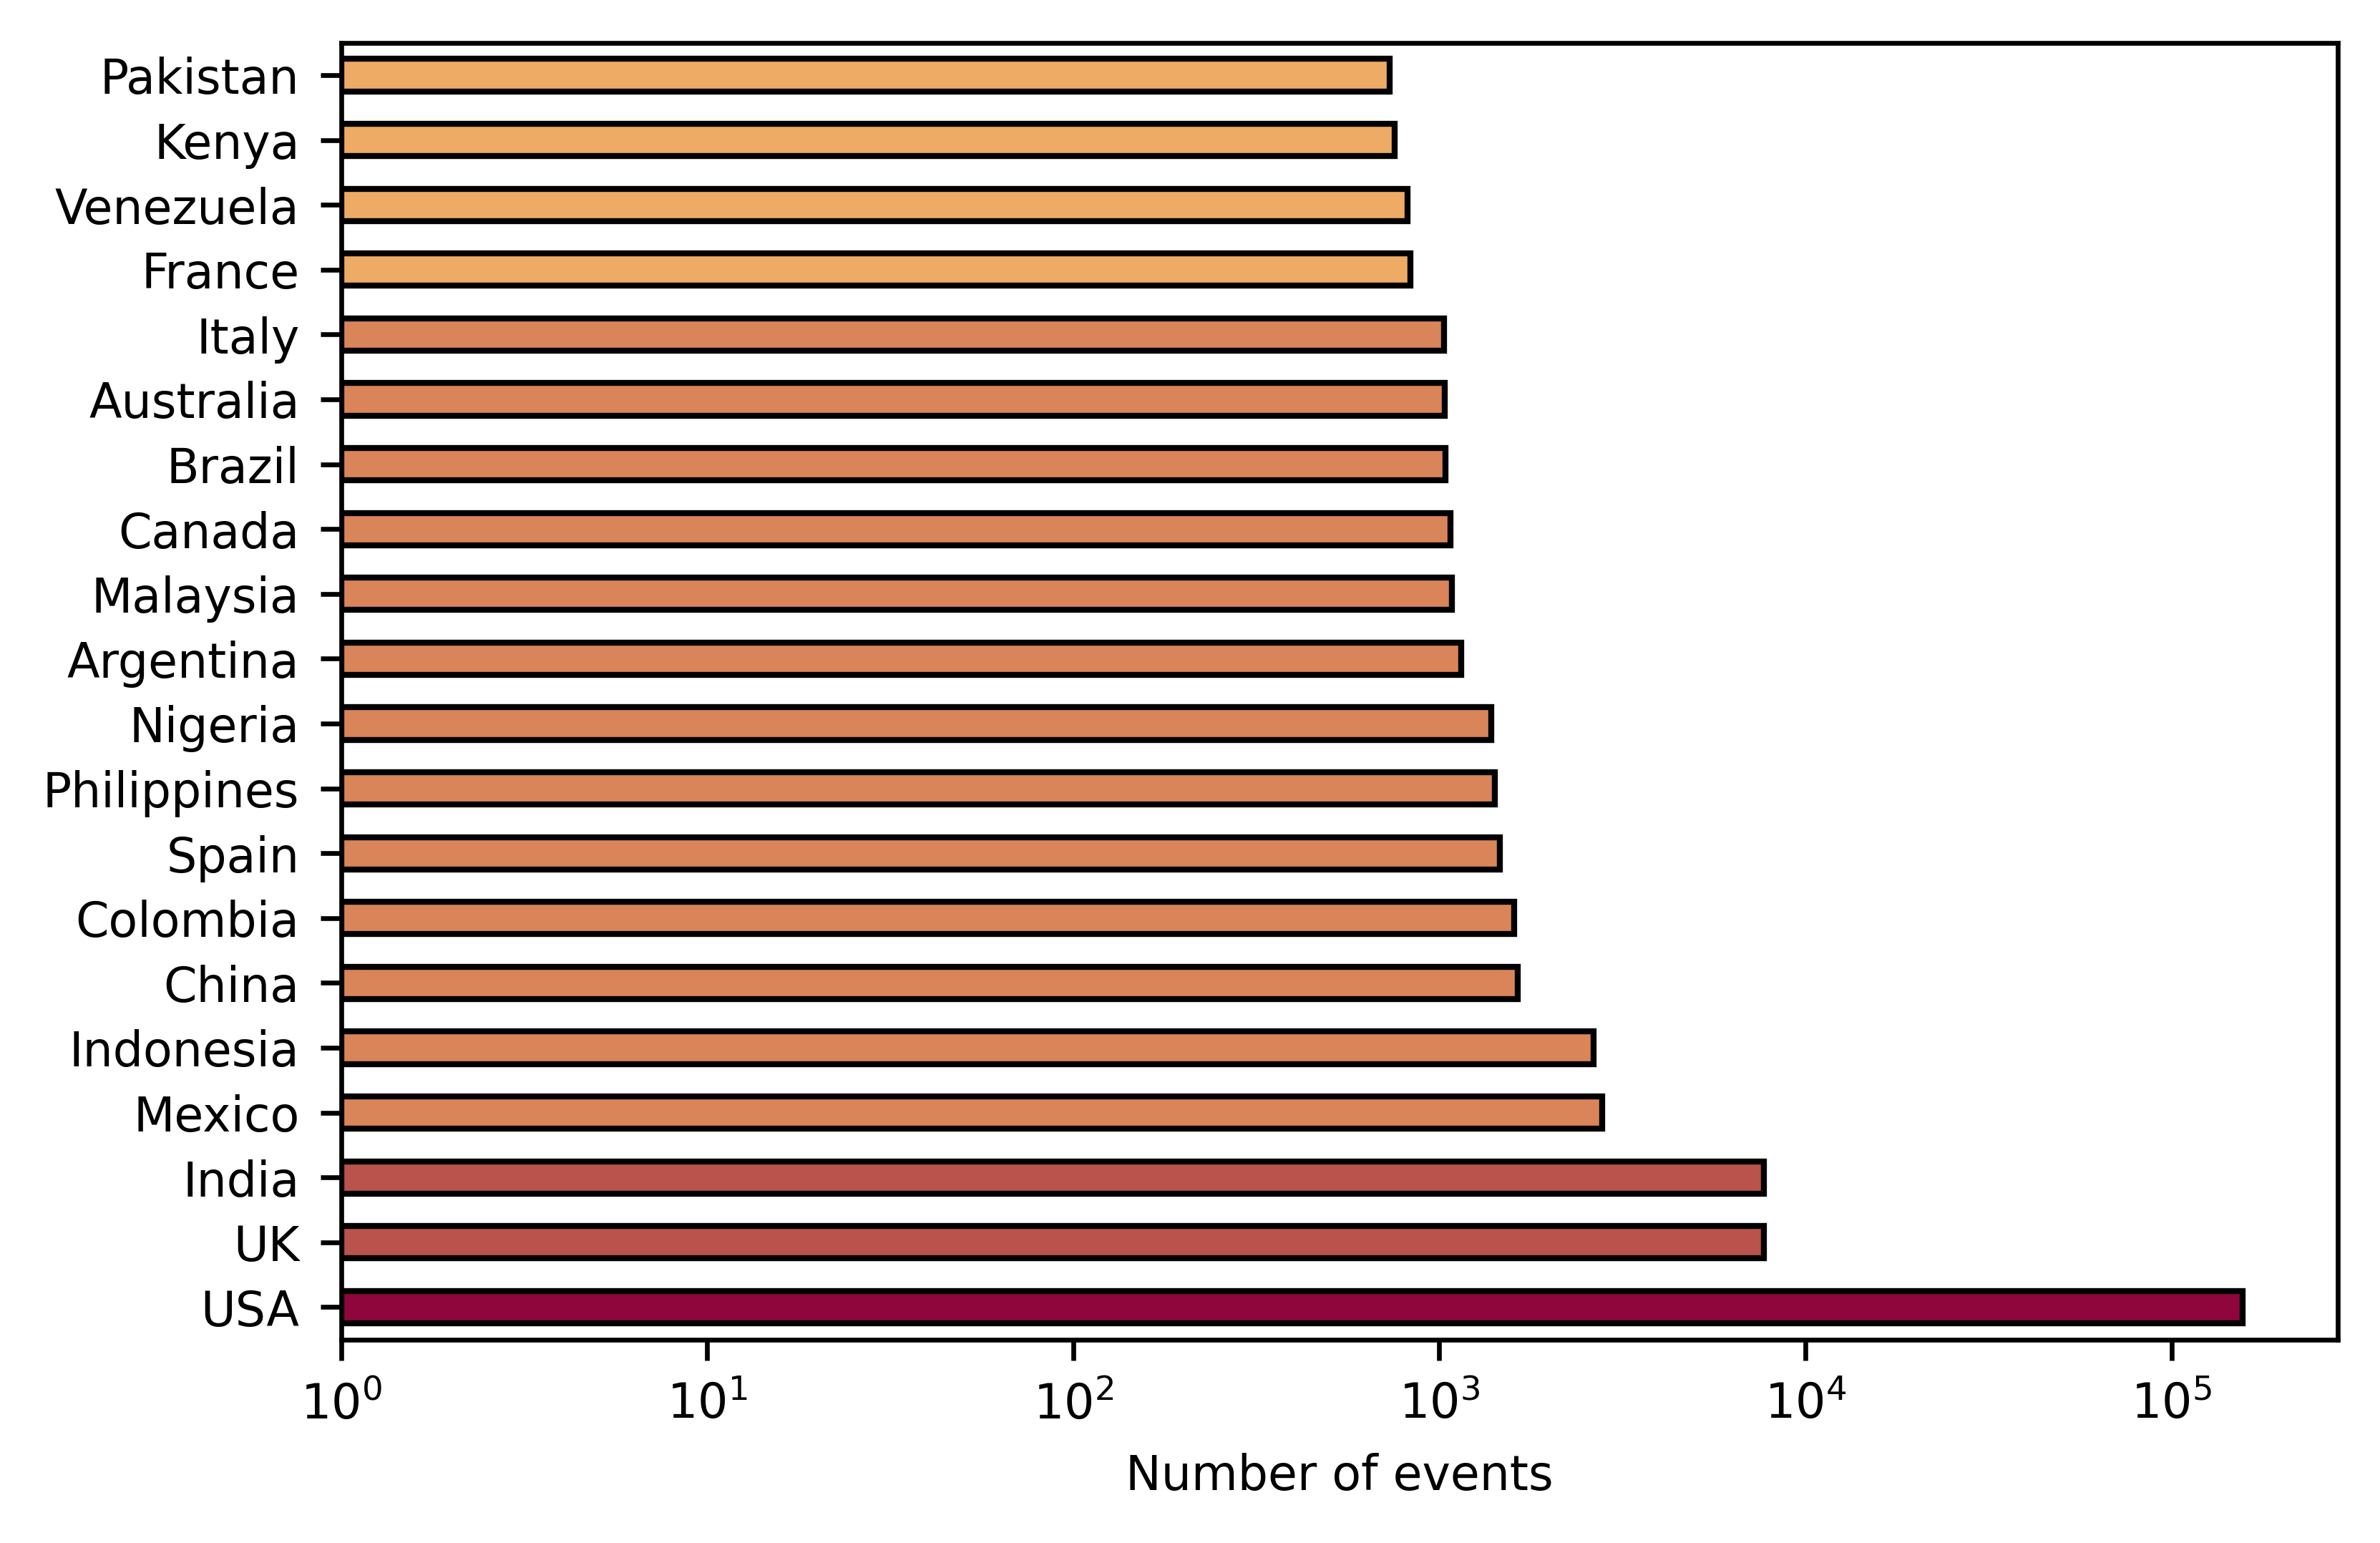

In [21]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
countries= world.sort_values('events', ascending=False)[:20]
world.sort_values('events', ascending=False).events[:20].plot(kind='barh', xlabel='', ax=ax,
                        color=events_cmap(countries.events/countries.events.max()),
                                                              edgecolor='k',alpha=1)
ax.set_xlabel('Number of events')
# ax.set_xscale('log')


countries.index= countries.index.str.replace('United States of America', 'USA')
countries.index= countries.index.str.replace('United Kingdom', 'UK')
# ax.set_yticks()
ax.set_yticklabels(countries.index)
ax.set_xticklabels(['$10^%d$'%i for i in range(6)]);
# for i in range(len(countries)):
#     ax.text(countries.iloc[i,5]+.1, i-0.1, int(countries.iloc[i,-1]))
    

In [22]:
fig.savefig('src/countries_event_counts.png',dpi=300)

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Use the colorbar set_ticks() method instead.
  # This is added back by InteractiveShellApp.init_path()


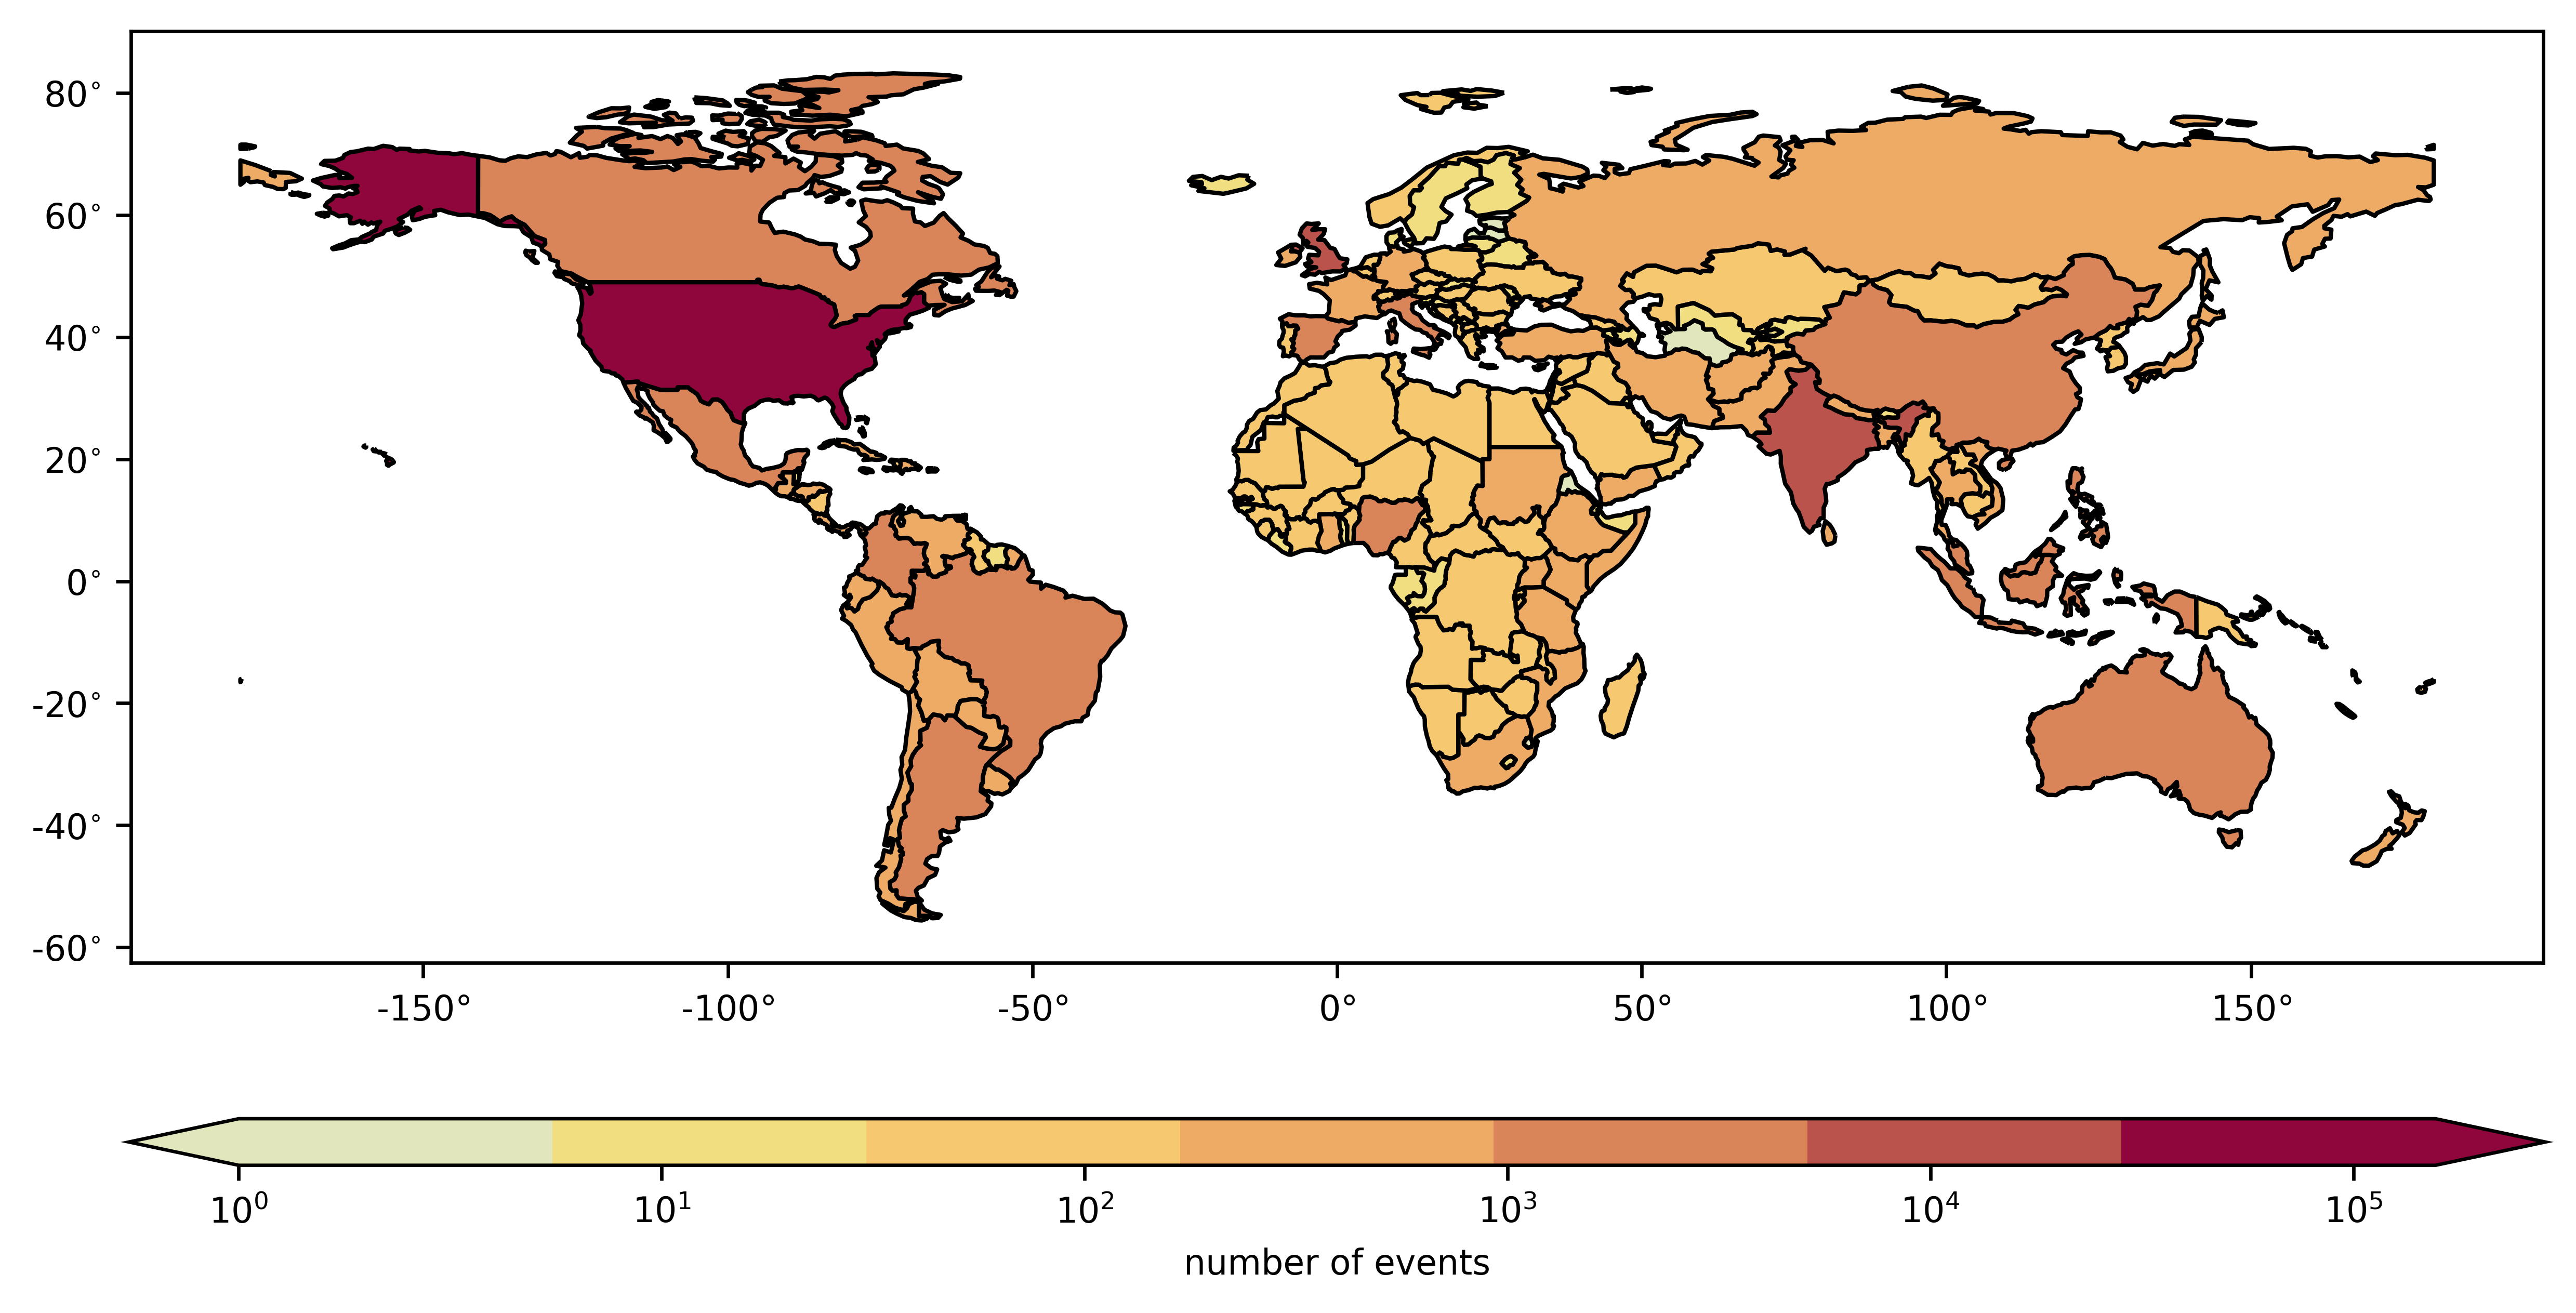

In [23]:
fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

view= world.plot(column='events',ax=ax, cmap=events_cmap, legend=True, cax=cax, edgecolor='black',
           legend_kwds={'label': "number of events",
                        'orientation': "horizontal",
                       "ticks": np.arange(6),
                       "extend": 'both'})
cax.set_xticks(np.arange(6))
cax.set_xticklabels(['$10^%d$'%i for i in range(6)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)]);

In [25]:
fig.savefig('src/global_events.png', dpi=500)

In [7]:
import ee

In [8]:
ee.Initialize()

In [11]:
states= ee.FeatureCollection('TIGER/2016/States').getInfo()

In [12]:
US_states= gpd.GeoDataFrame()

In [13]:
from shapely.geometry import Polygon, MultiPolygon

In [183]:
US_states= gpd.GeoDataFrame()
for i,fea in enumerate(states['features']):
#     if fea['properties']['NAME'] not in ['American Samoa', 'Puerto Rico',
#                                          'United States Virgin Islands',
#                                         'Commonwealth of the Northern Mariana Islands','Guam',
#                                         'Rhode Island', 'Alaska', 'Hawaii']:
    US_states.loc[i,'name']= fea['properties']['NAME']
    US_states.loc[i,'type']= fea['geometry']['type']
    if fea['geometry']['type']=='Polygon':
        US_states.loc[i,'geometry']= Polygon(fea['geometry']['coordinates'][0])
    elif fea['geometry']['type']=='MultiPolygon':
        US_states.loc[i,'geometry']= gpd.GeoSeries([MultiPolygon([Polygon(poly[0]) for poly in fea['geometry']['coordinates']])]).values
    elif fea['geometry']['type']=='GeometryCollection':
        for each in fea['geometry']['geometries']:
            if each['type']=='Polygon':
                US_states.loc[i,'geometry']= Polygon(each['coordinates'][0])


In [180]:
def countByStates(state, country):
    masks= gdf[gdf.COUNTRY==country].geometry.within(state.geometry)
    _gdf= gdf[gdf.COUNTRY==country][masks]
    
    return len(_gdf)

def getIndByStates(state, country):
    masks= gdf[gdf.COUNTRY==country].geometry.within(state.geometry)
    
    return gdf[gdf.COUNTRY==country][masks].index.values

In [91]:
US_states['events']= US_states.apply(countByStates, axis=1)

In [96]:
US_states['events_log']= np.log10(US_states['events'])

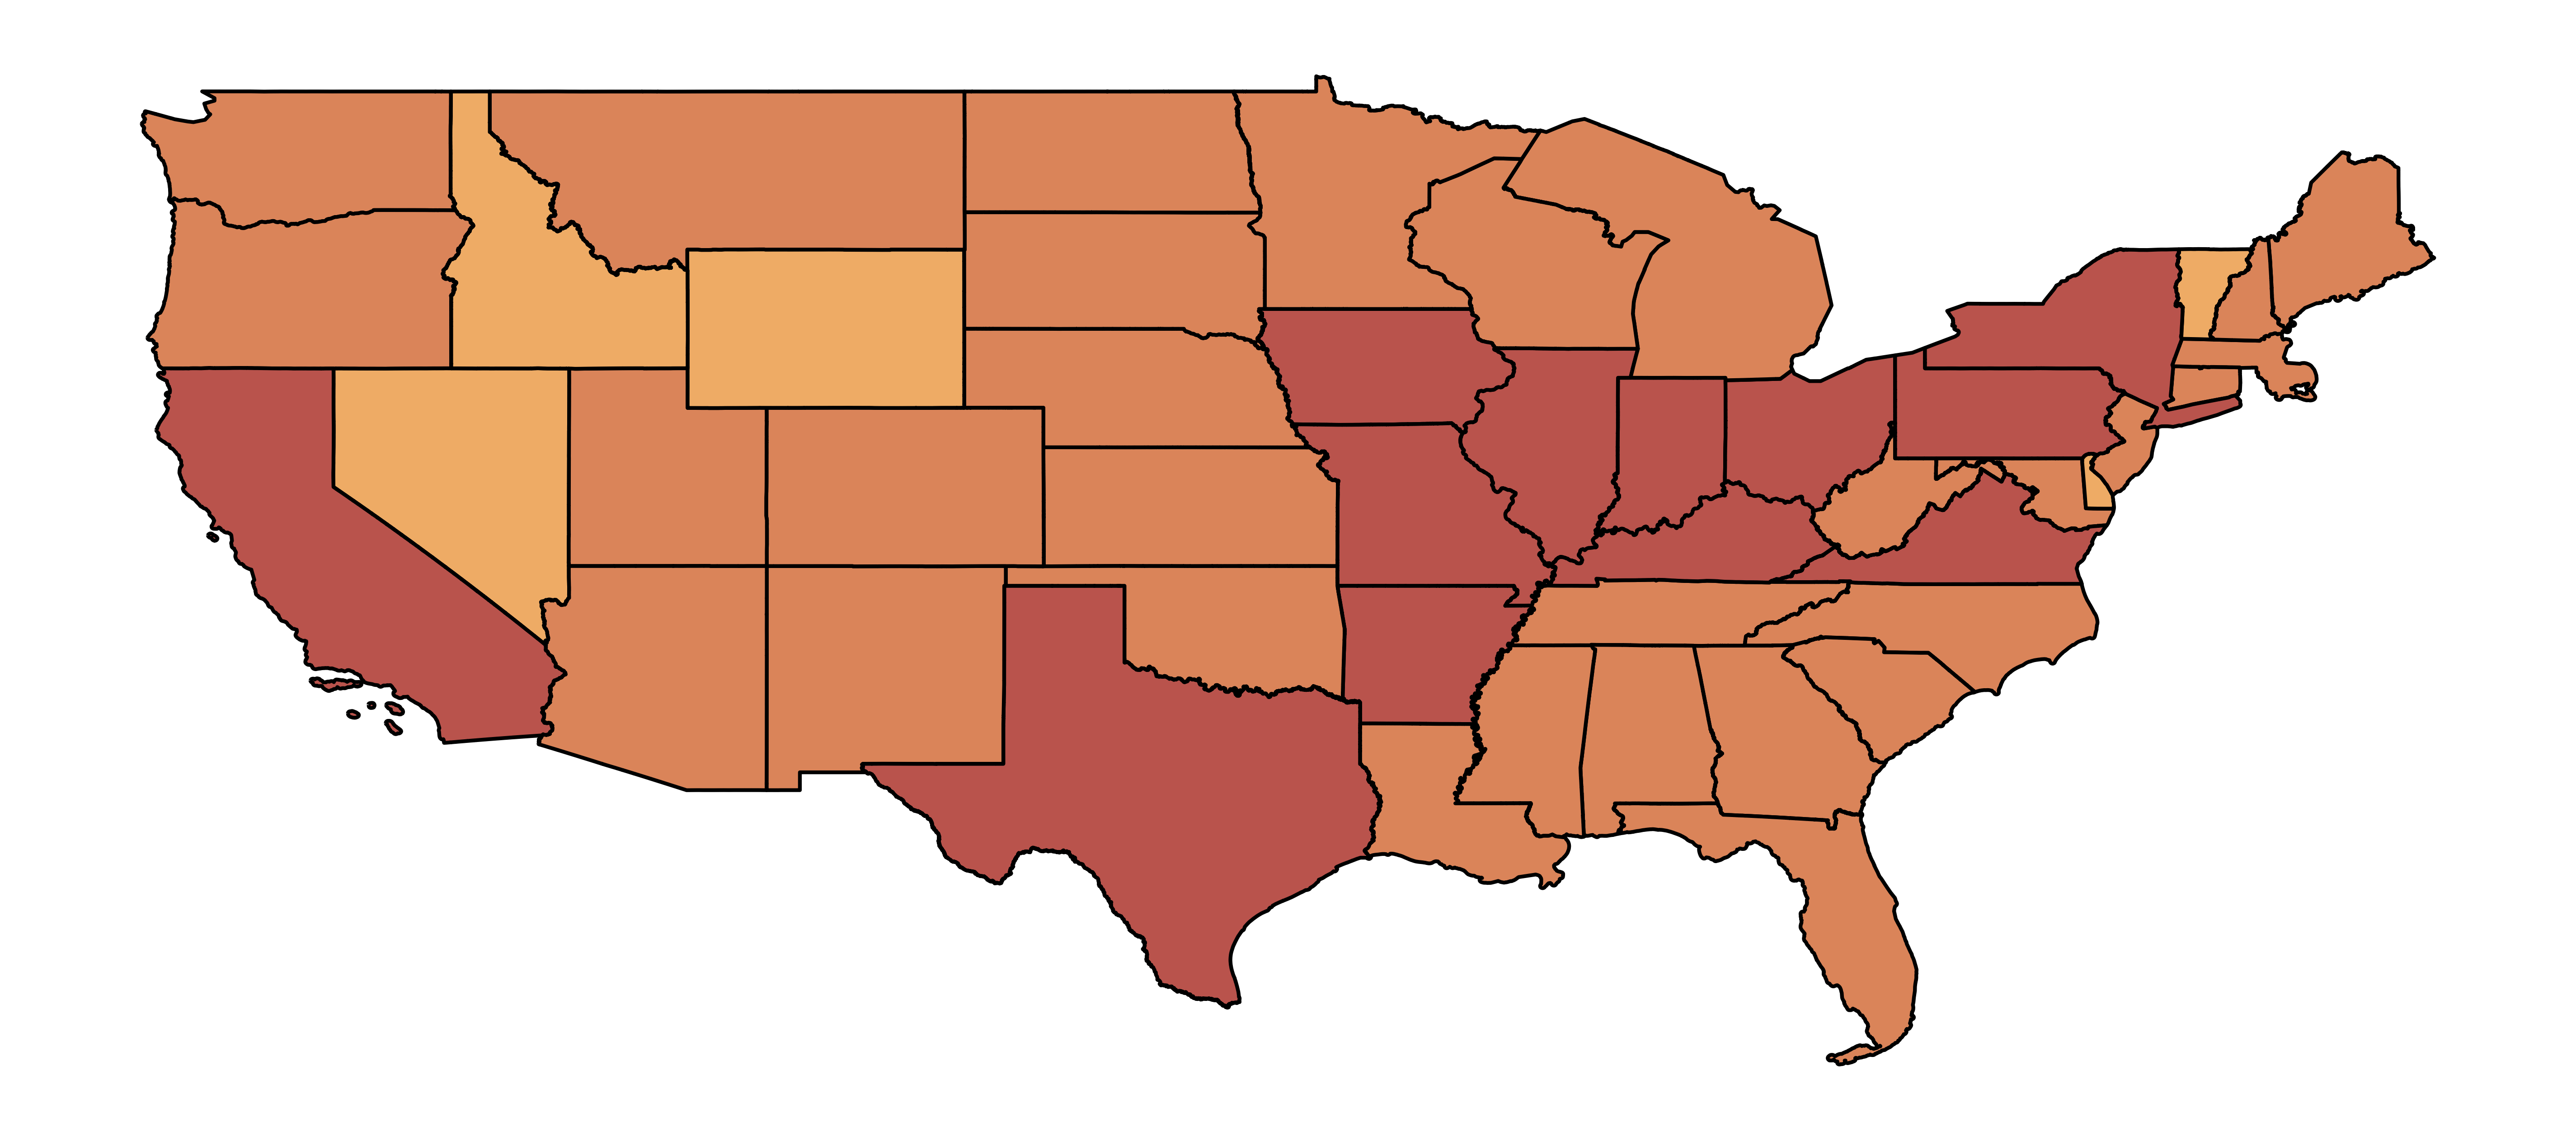

In [125]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
US_states.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [126]:
fig.savefig('src/US_floods_states.png', dpi=500)

In [101]:
US_states.to_file('US_floods_states')

In [186]:
# clean states

IDs= US_states.apply(getIndByStates, axis=1, country='United States of America')
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= US_states.loc[i, 'name']

# Indian states

In [103]:
Ind_states= gpd.read_file('Indian states/Indian_States.shp')

In [109]:
Ind_states['events']= Ind_states.apply(countByStates, axis=1,country='India')

In [127]:
Ind_states['events_log']= np.log10(Ind_states['events'])

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [133]:
Ind_states.loc[Ind_states.events==0, 'events_log']= np.nan

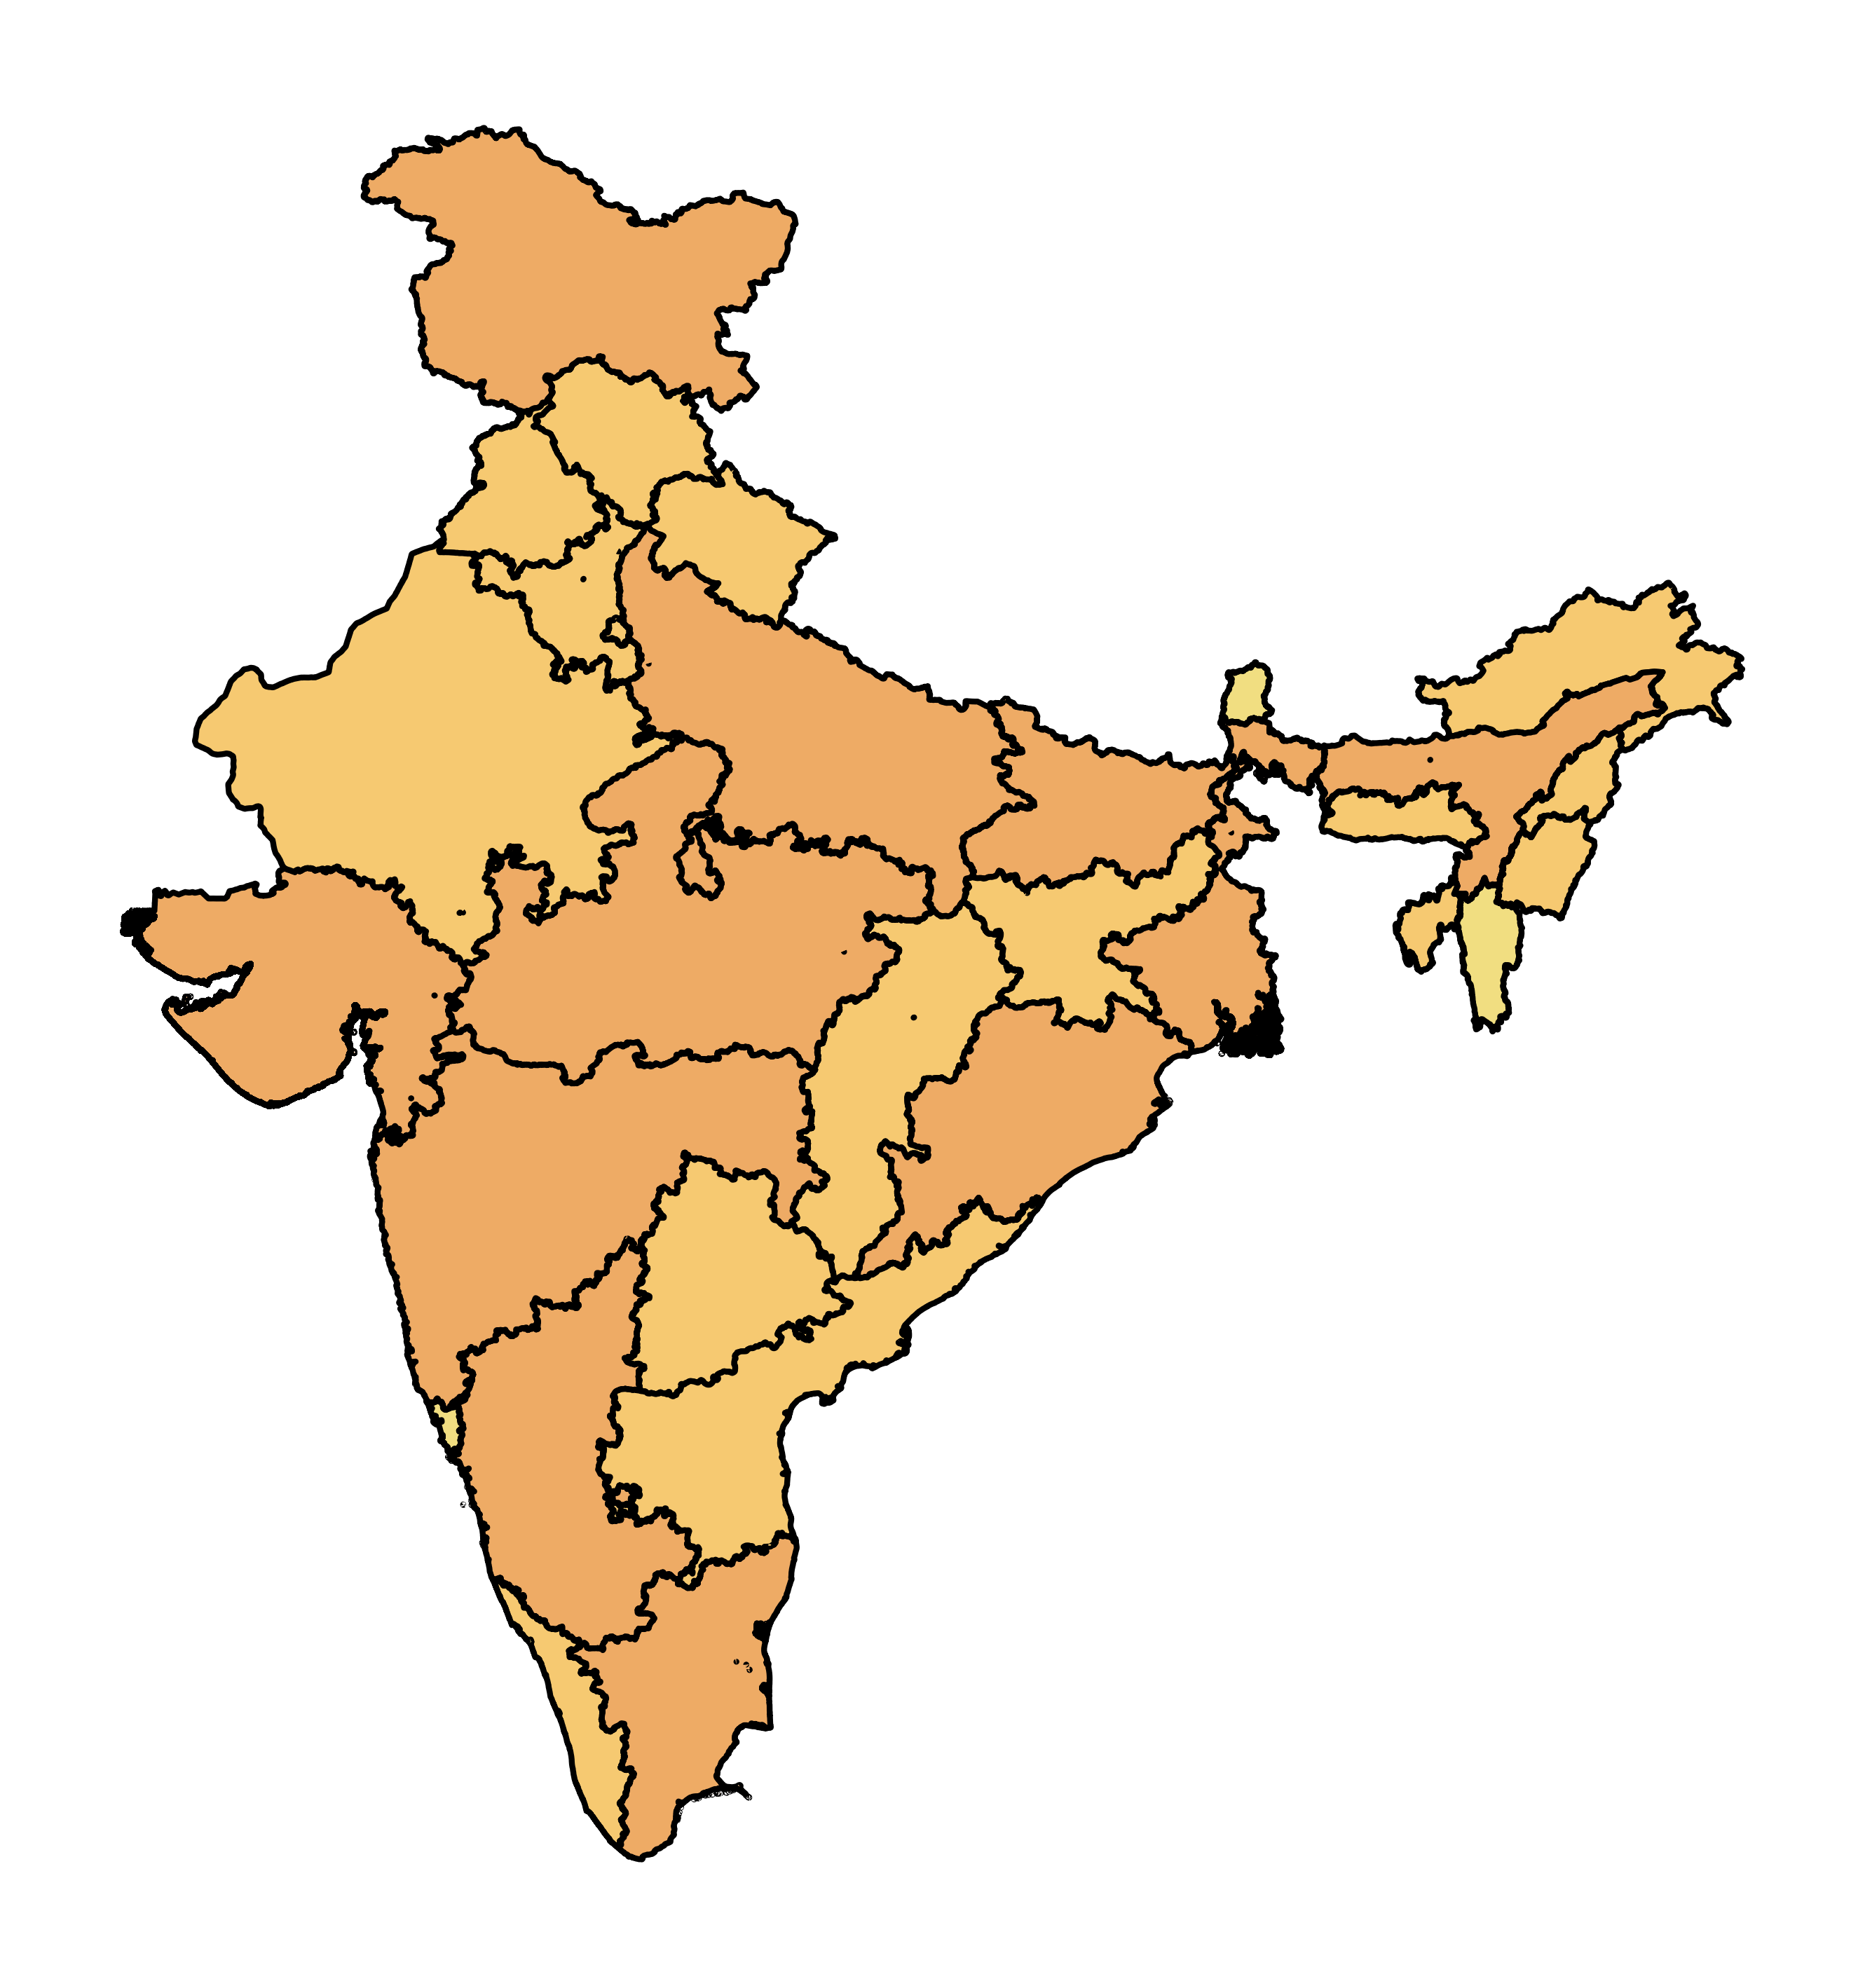

In [135]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
Ind_states.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [136]:
fig.savefig('src/India_floods_states', dpi=500)

In [174]:
# clean states

IDs= Ind_states.apply(getIndByStates, axis=1, country='India', name='st_nm')

In [175]:
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= Ind_states.loc[i, 'st_nm']

# China province

In [139]:
CHN_prov= gpd.read_file('China_prov/chn_admbnda_adm1_ocha_2020.shp')

In [141]:
CHN_prov['events']= CHN_prov.apply(countByStates, axis=1, country='China')

In [143]:
CHN_prov['events_log']= np.log10(CHN_prov['events'])
CHN_prov.loc[CHN_prov.events==0, 'events_log']= np.nan

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


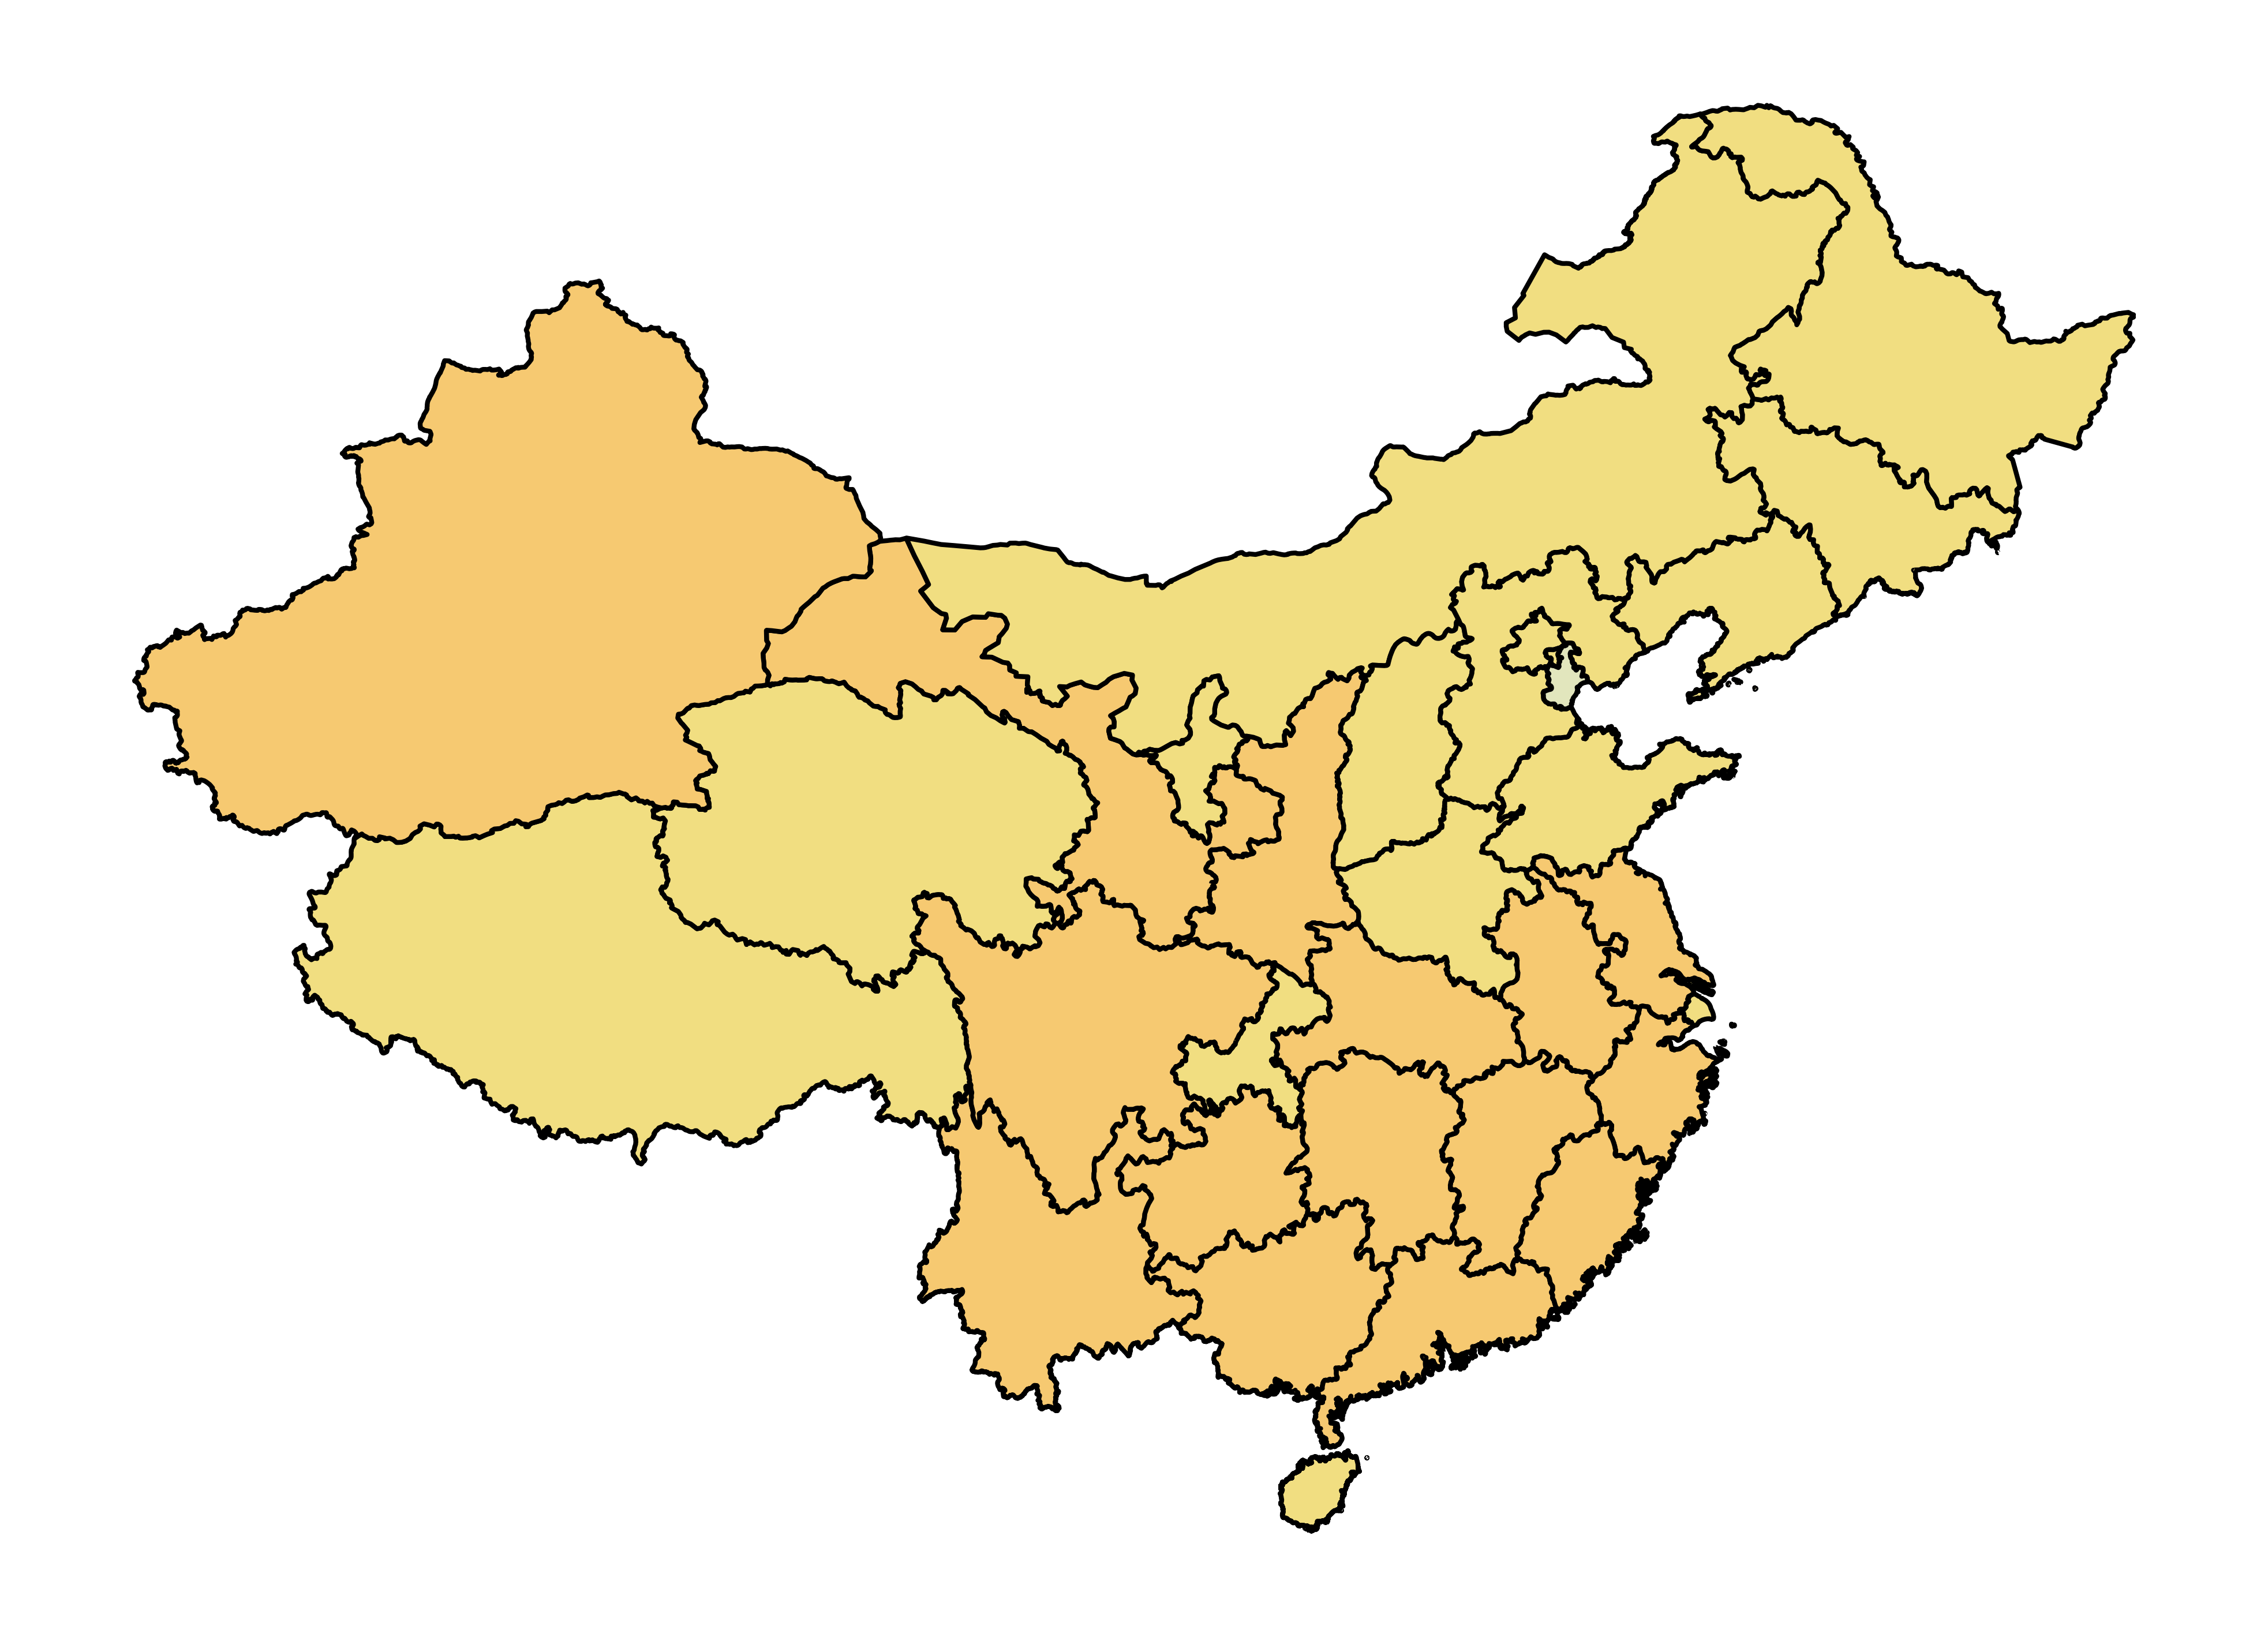

In [144]:
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
CHN_prov.plot(column='events_log', ax=ax, cmap=events_cmap,edgecolor='black',
               vmin=0, vmax=5)
ax.axis('off');

In [145]:
fig.savefig('src/China_floods_states.png', dpi=500)

In [181]:
# clean states
IDs= CHN_prov.apply(getIndByStates, axis=1, country='China')
for i,ids in enumerate(IDs):
    df.loc[ids, 'STATE']= CHN_prov.loc[i, 'ADM1_EN']

In [188]:
df.to_csv('merged_v0.43.csv')

# Get global watersheds

In [4]:
df= pd.read_csv('merged_v0.45.csv', index_col='ID', usecols=['ID','LON','LAT','DATE_BEGIN',
                                                              'COUNTRY','STATE'])

In [9]:
watersheds= ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_4').getInfo()['features']

In [41]:
from shapely.geometry import shape, MultiPoint, Point

In [21]:
geom = [shape(watershed['geometry']) for watershed in watersheds]

In [22]:
geo_watersheds= gpd.GeoDataFrame({'geometry':geom})

for i,watershed in enumerate(watersheds):
#     print(shape(watershed['geometry']))
#     geo_watersheds.loc[i, 'geometry']=shape(watershed['geometry'])
    geo_watersheds.loc[i, 'ID']= watershed['properties']['HYBAS_ID']
    geo_watersheds.loc[i, 'UP_AREA']= watershed['properties']['UP_AREA']
    

In [45]:
gdf= gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.LON, df.LAT))

In [57]:
def groupBySeason(watershed):
    try:
        masks= gdf.geometry.within(watershed.geometry)
#     gdf.loc[masks, 'Basin']= watershed.HYBAS_ID
    
        return gdf.loc[masks].index, watershed.ID
    except ValueError:
        return np.nan, np.nan
    

In [34]:
clean_df= df[(~pd.isna(df.LON)) & (~pd.isna(df.LAT))]

In [59]:
results= geo_watersheds.apply(groupBySeason, axis=1)

In [60]:
df['WATERSHED_ID']= np.nan

In [61]:
for ids, watershed_id in results:
    df.loc[ids, 'WATERSHED_ID']= watershed_id

In [6]:
#format database date
def format_date(x):
    if not pd.isna(x.DATE_BEGIN):
        if isinstance(x.DATE_BEGIN, int):
            date= str(x.DATE_BEGIN)
        elif isinstance(x.DATE_BEGIN, float):
            date= str(int(x.DATE_BEGIN))
        else:
            date= x.DATE_BEGIN
        if len(date)==4:
            return pd.to_datetime(date, format='%Y')
        elif len(date)==6:
            return pd.to_datetime(date, format='%Y%m')
        elif len(date)==8:
            return pd.to_datetime(date, format='%Y%m%d')
        elif len(date)==10:
            return pd.to_datetime(date, format='%Y%m%d%H')
        elif len(date)==12:
            return pd.to_datetime(date, format='%Y%m%d%H%M')
        elif len(date)==14:
            return pd.to_datetime(date, format='%Y%m%d%H%M%S')
        else:
            return np.nan
    else:
        return np.nan
    
dates= df.apply(format_date, axis=1)

In [85]:
for mon in range(1,13):
    geo_watersheds['%02d'%mon]= 0
    for i in range(len(geo_watersheds)):
        geo_watersheds.loc[i,'%02d'%mon]= len(df[(df.WATERSHED_ID==geo_watersheds.loc[i,'ID'])&\
                                                 (dates.dt.month==mon)])

In [28]:
def mapMostMonths(x):
    cases= np.array([x['%02d'%m] for m in range(1,13)])
    if (cases==0).all():
        return np.nan
    else:
        return np.argmax(cases)+1
        

geo_watersheds['most_cases_by_month']= geo_watersheds.apply(mapMostMonths,axis=1)

In [126]:
geo_watersheds.to_file('global_watershed_v4')

## Plots

In [26]:
geo_watersheds= gpd.read_file('global_watershed_v4')

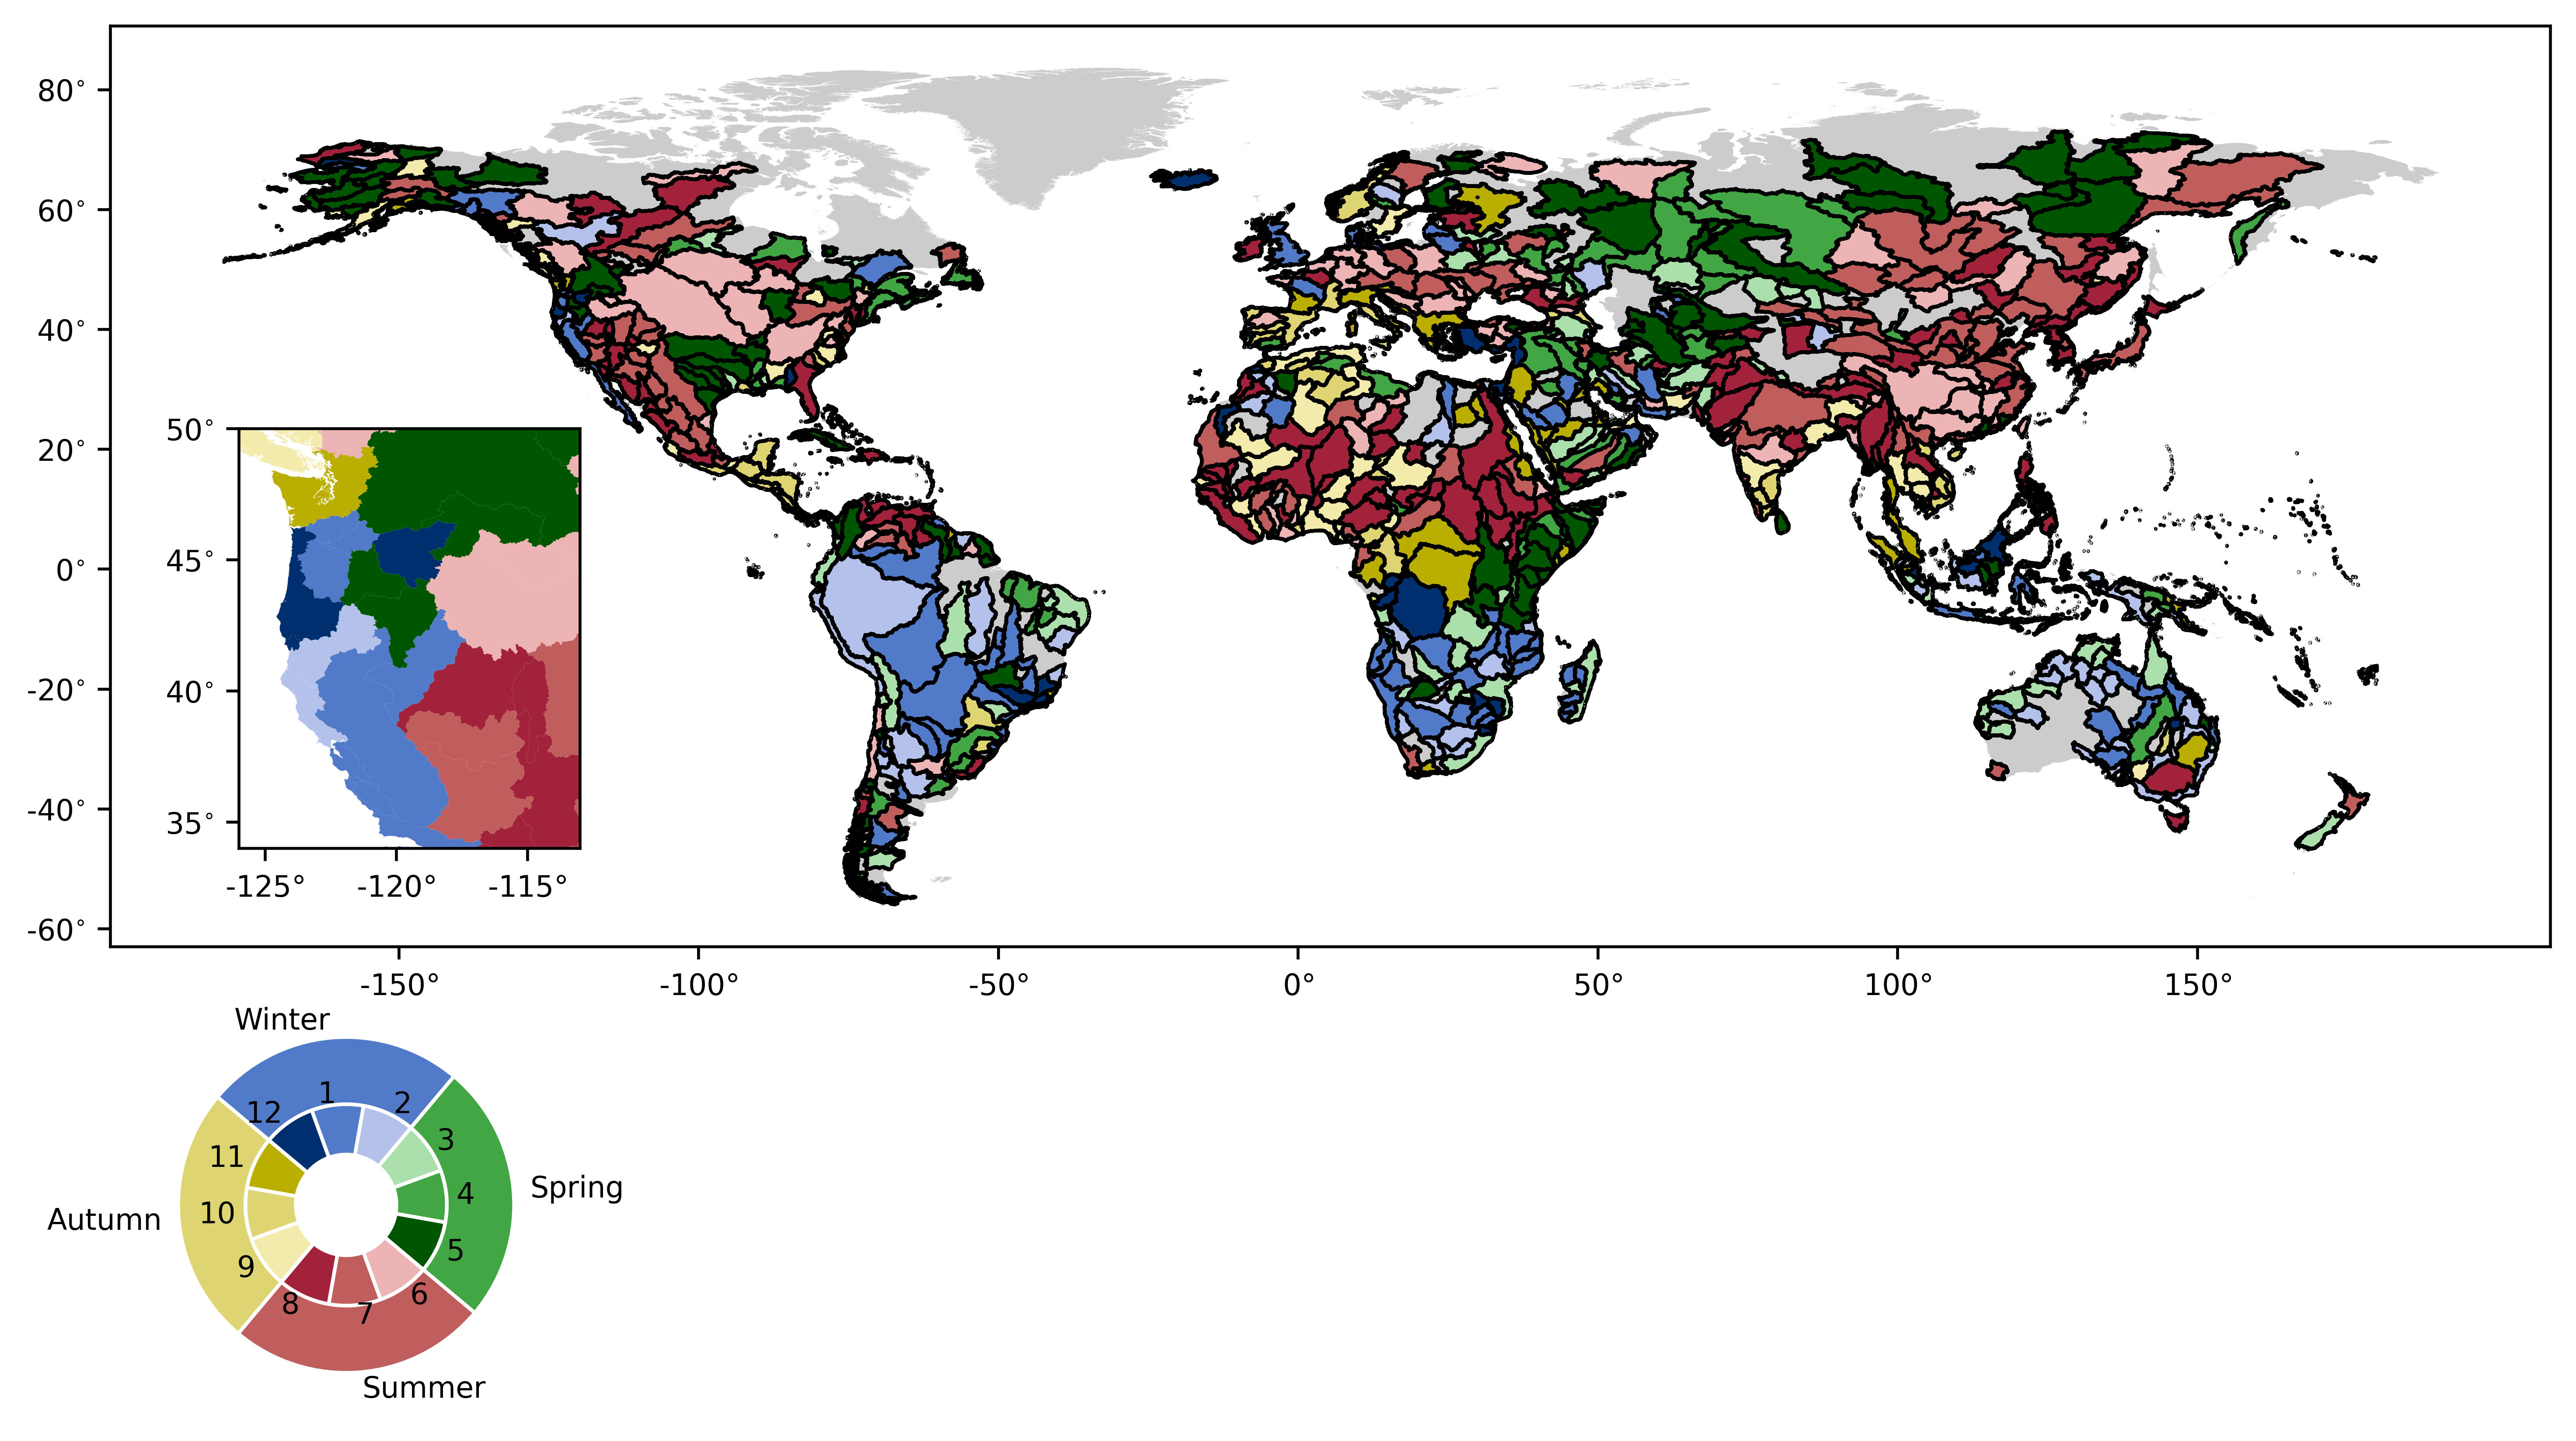

In [72]:
#("#002F70","#517AC9","#B4C2EB","#F6F6F6","#EDB4B5","#C05D5D","#5F1415")
colors= ["#517AC9","#B4C2EB","#ABDFAC","#42A644","#005600","#EDB4B5","#C05D5D","#A2223C",
        "#F2EBAC","#DED471","#BAAE00","#002F70"]
seasons_cmap= ListedColormap(colors)
fig= plt.figure(figsize=(12,8))
ax= fig.add_subplot(111)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.5)
geo_watersheds.plot( alpha=0.2, ax=ax)
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax, legend=False,edgecolor='black',
           legend_kwds={'label': "Month",
                        'orientation': "horizontal",
                       "ticks": [1.2,2.3,3.3,4.2,5.1,6,7,7.9,8.8,9.8,10.6,11.8],
                       "extend": 'both'})
# cax.set_xticks([1,2.2,3.2,4.1,5.1,6,7,7.9,8.8,9.8,10.6,12])
# cax.set_xticklabels(['%02d'%i for i in range(1,13)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)])
ax2=fig.add_axes([0.12,0.33,0.2,0.2])
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax2)
ax2.set_xlim([-126.0,-113.0])
ax2.set_ylim([34,50])
ax2.set_xticks(np.arange(-125,-110,5))
ax2.set_xticklabels(['%d$\degree$'%i for i in range(-125,-110,5)])
ax2.set_yticks(np.arange(35,55,5))
ax2.set_yticklabels(['%d$^{\circ}$'%i for i in range(35,55,5)])

legend_ax= fig.add_axes([0.1,0.06,0.2,0.2])
legend_ax.pie([0.083333333]*12, colors=colors, labels=np.arange(1,13),startangle=110,counterclock=False, radius=0.6,
      wedgeprops=dict(width=0.3, edgecolor='w'));
legend_ax.pie([0.25]*4, radius=1,wedgeprops=dict(width=0.4, edgecolor='w'),startangle=140,counterclock=False,
      colors=["#517AC9","#42A644","#C05D5D","#DED471"], labels=['Winter','Spring','Summer','Autumn']);                 

In [73]:
fig.savefig('src/watersheds_by_month.png',dpi=500)

In [ ]:
#("#002F70","#517AC9","#B4C2EB","#F6F6F6","#EDB4B5","#C05D5D","#5F1415")
colors= ["#517AC9","#B4C2EB","#ABDFAC","#42A644","#005600","#EDB4B5","#C05D5D","#5F1415",
        "#E6B494","#A56A32","#492900","#002F70"]
seasons_cmap= ListedColormap(colors)
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot(111)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.5)
geo_watersheds.plot( alpha=0.2, ax=ax)
geo_watersheds.plot(column='most_cases_by_month', cmap=seasons_cmap,ax=ax,cax=cax, legend=False,edgecolor='black',
           legend_kwds={'label': "Month",
                        'orientation': "horizontal",
                       "ticks": [1.2,2.3,3.3,4.2,5.1,6,7,7.9,8.8,9.8,10.6,11.8],
                       "extend": 'both'})
# cax.set_xticks([1,2.2,3.2,4.1,5.1,6,7,7.9,8.8,9.8,10.6,12])
cax.set_xticklabels(['%02d'%i for i in range(1,13)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)])
ax.set_xlim([-126.0,-113.0])
ax.set_ylim([34,50])
ax.axis('off');                   

# Impacts

In [4]:
df= pd.read_csv('merged_v0.46.csv', index_col='ID')

In [7]:
dates= df.apply(format_date, axis=1)

In [8]:
df['year']= dates.dt.year

## adjust inflation factors before doing economic assessments

Data: GPD deflactor values by Country

In [37]:
df_factors= pd.read_csv('GDP_deflactor.csv',header=None,
                        index_col=[0],names=['year']+list(np.arange(1980,2021))).transpose()

In [38]:
df_factors= df_factors.interpolate(method='linear',limit_area='outside')

In [43]:
def adjust_damage(feature):
    if not pd.isna(feature.DAMAGE) and not np.isnan(feature.DAMAGE) and not np.isnan(feature.year):
        year=int(feature.year)
        if year<1980 or pd.isna(feature.COUNTRY) or feature.COUNTRY not in df_factors.columns:
#             print('country name or year not satisfying')
            return np.nan

        else:
            factor= df_factors.loc[year,feature.COUNTRY]
            if factor==0:
#                 print('factor 0!!!')
                return np.nan
            else:
#                 print(feature.DAMAGE, factor)
                return feature.DAMAGE/(factor/100.)
    else:
#         print('not satisfying')
        return np.nan

In [44]:
damages= df.apply(adjust_damage, axis=1)

In [46]:
df['adjusted_damage']= damages

(1980.0, 2022.4399999999998)

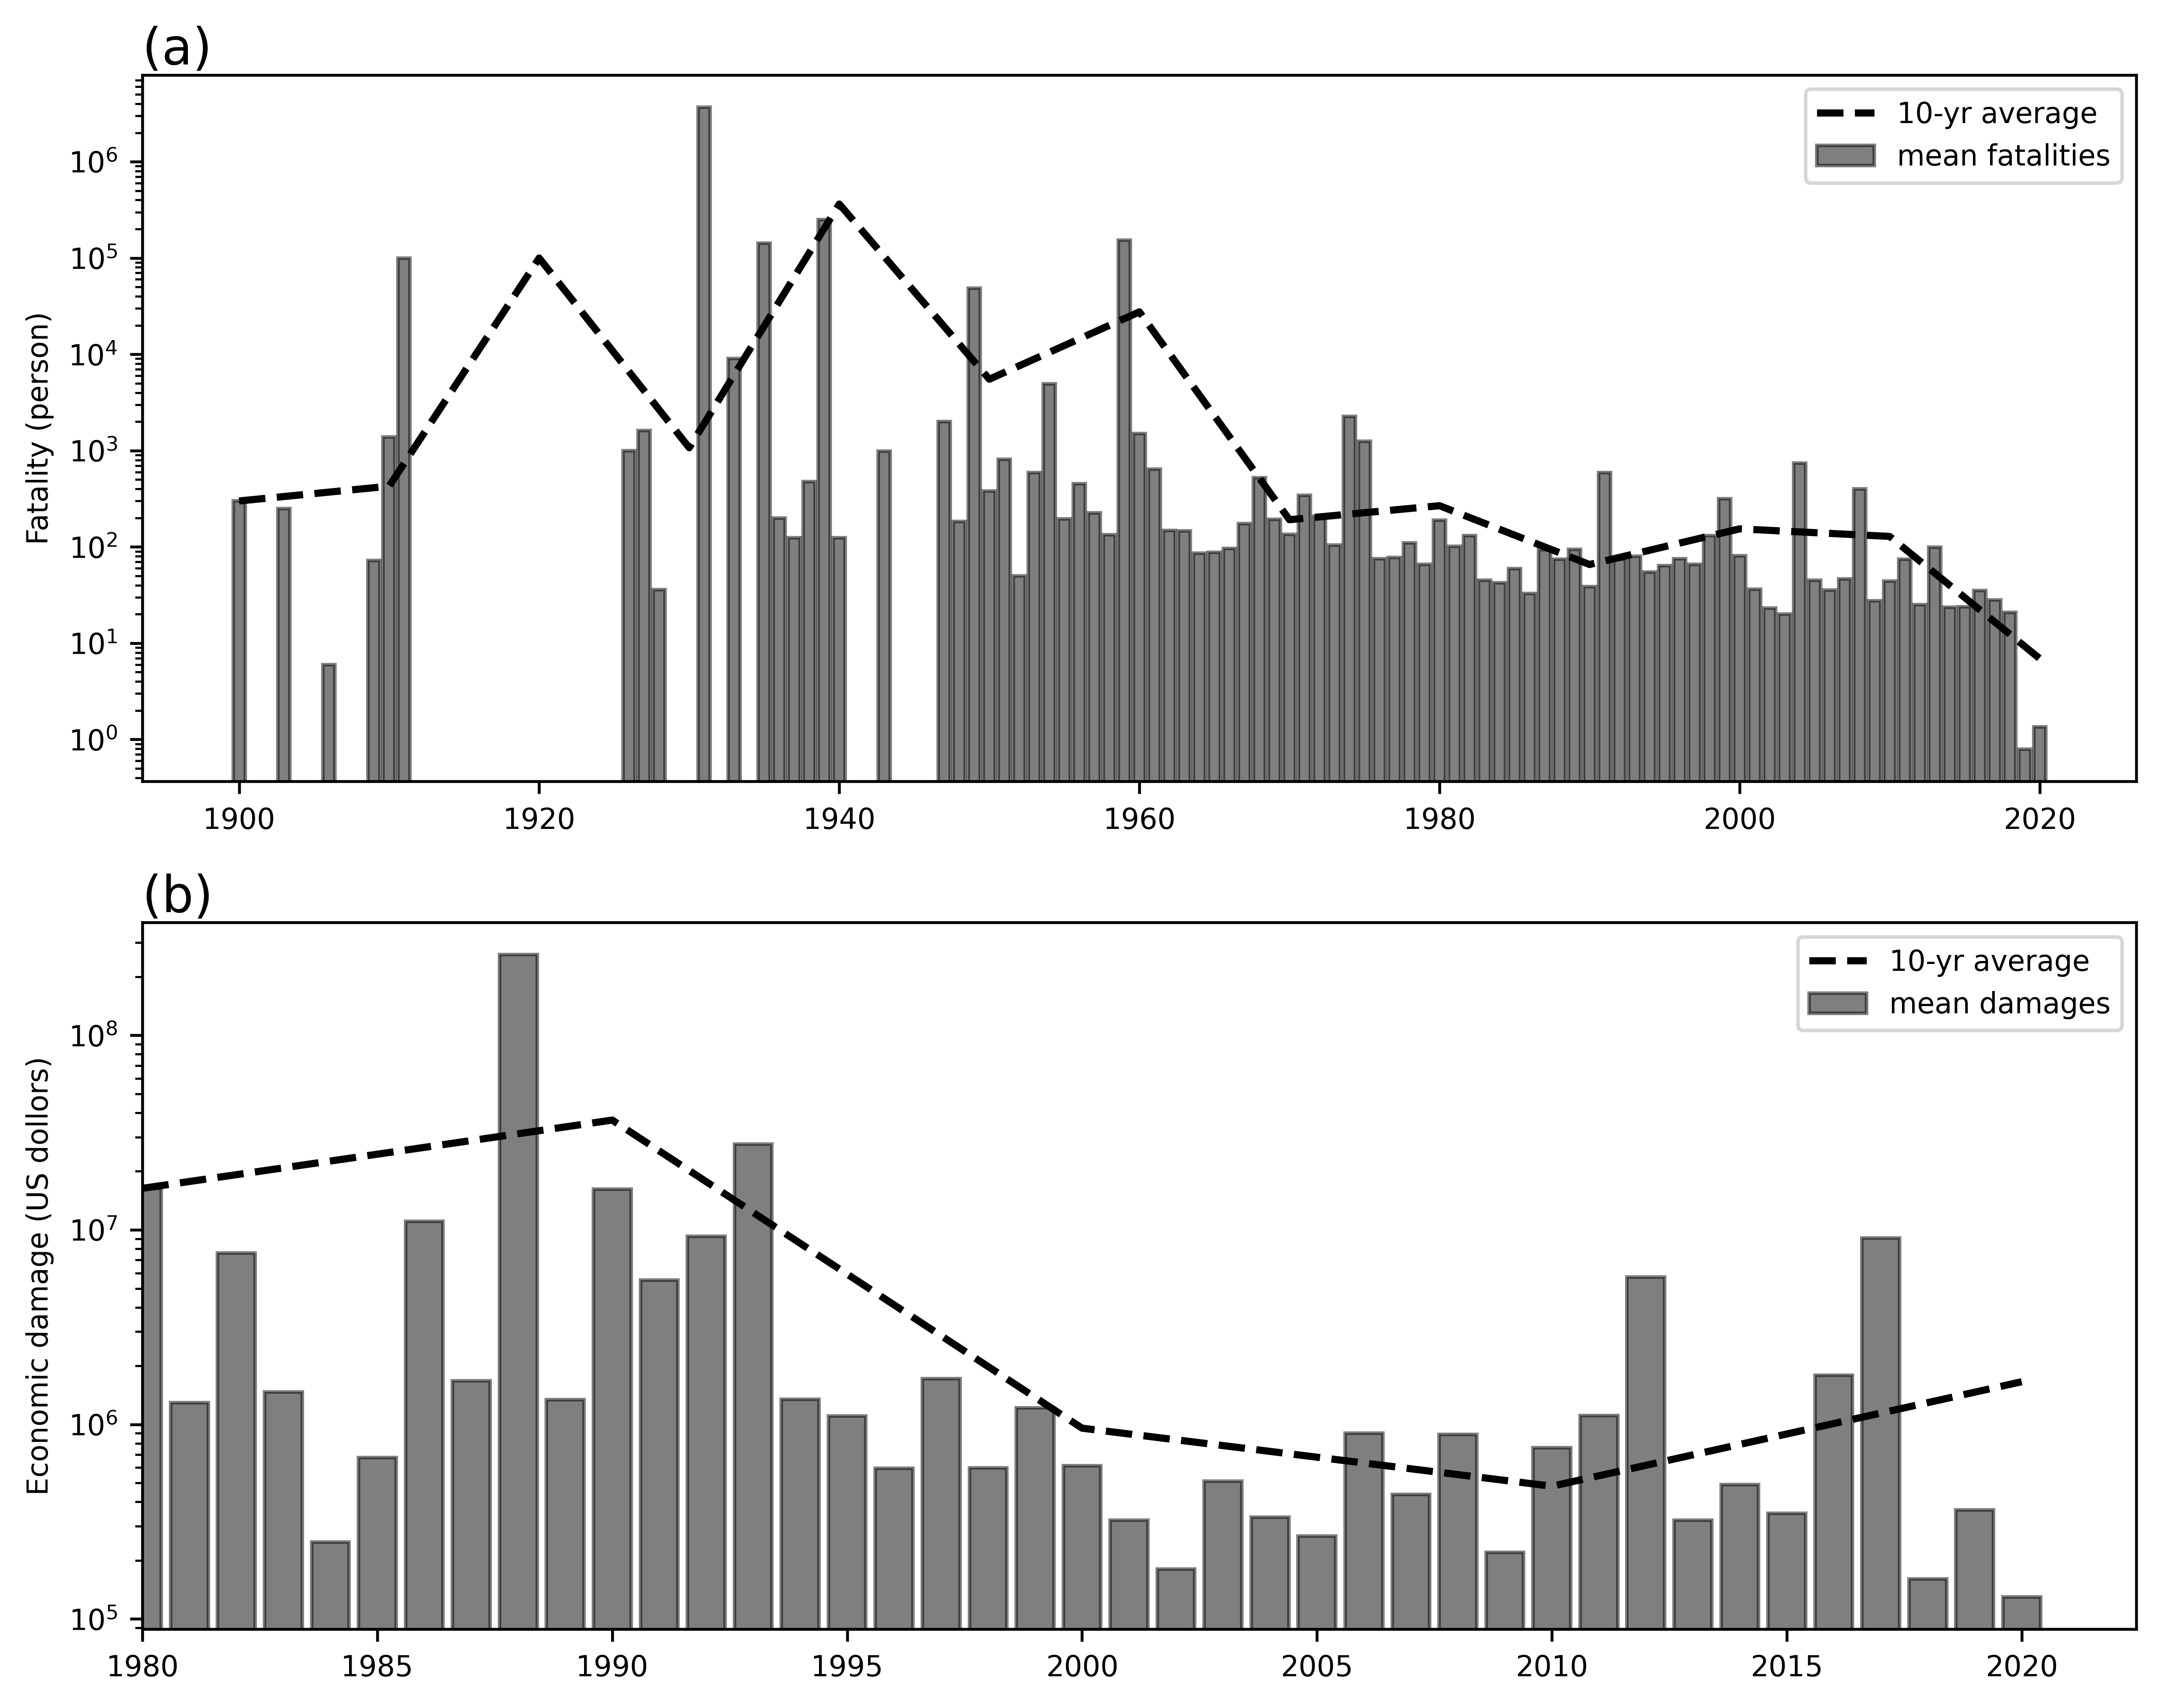

In [47]:
fig= plt.figure(figsize=(10,8))
ax= fig.add_subplot(211)
ax.set_yscale('log')
fatalities= df[(~pd.isna(df.FATALITY)) & (~pd.isna(df.year))].groupby('year').mean()['FATALITY']
ax.bar(fatalities.index, fatalities.values, alpha=0.5, edgecolor='k', label='mean fatalities')
df_fat= pd.DataFrame(index=dates)
df_fat['fatalities']= df.FATALITY.values
average= df_fat.resample('10Y').mean()
ax.plot(average.index.year, average.values, linestyle='dashed', linewidth=2, label='10-yr average')
ax.legend()
ax.set_title('(a)', loc='left', pad=1, fontsize=14)
ax.set_ylabel('Fatality (person)')

# fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(212)
ax.set_yscale('log')
fatalities= df[(~pd.isna(df.adjusted_damage)) & (~pd.isna(df.year))].groupby('year').mean()['adjusted_damage']
ax.bar(fatalities.index, fatalities.values, alpha=0.5, edgecolor='k', label='mean damages')
df_fat= pd.DataFrame(index=dates)
df_fat['loss']= df.adjusted_damage.values
average= df_fat.resample('10Y').mean()
ax.plot(average.index.year, average.values, linestyle='dashed', linewidth=2, label='10-yr average')
ax.legend()
ax.set_title('(b)', loc='left', pad=1, fontsize=14)
ax.set_ylabel('Economic damage (US dollors)')
ax.set_xlim([1980, None])
# ax.set_xticks(np.arange(0,121,5))
# ax.set_xticks(np.arange(0,121,5))
# ax.set_xticklabels(np.arange(1900,2021,5).astype(int));

In [48]:
fig.savefig('src/losses.png', dpi=300)

In [4]:
world.set_index('name', inplace=True)

In [22]:
world['losses']= df[df.DAMAGE>0].groupby('COUNTRY').mean()['DAMAGE']/1000000

In [49]:
world['counts']= df.groupby('COUNTRY').count()['DAMAGE']

In [6]:
US_states= gpd.read_file('US_floods_states')

In [7]:
US_states.set_index('name', inplace=True)

In [23]:
US_states['losses']= df.groupby('STATE').mean()['DAMAGE']/1000000

In [45]:
df[df.COUNTRY=='Germany'].DAMAGE.unique()

array([      nan, 12900000.,  2000000.])

In [50]:
world.columns

Index(['pop_est', 'continent', 'iso_a3', 'gdp_md_est', 'geometry', 'losses',
       'counts'],
      dtype='object')

In [58]:
countries.iloc[0].name

'Germany'

In [69]:
list(ax.get_yticklabels())[1]

Text(0, 1, 'Japan')

In [98]:
cmap(0.1)

(0.8549019607843137, 1.0, 0.2784313725490196, 1.0)

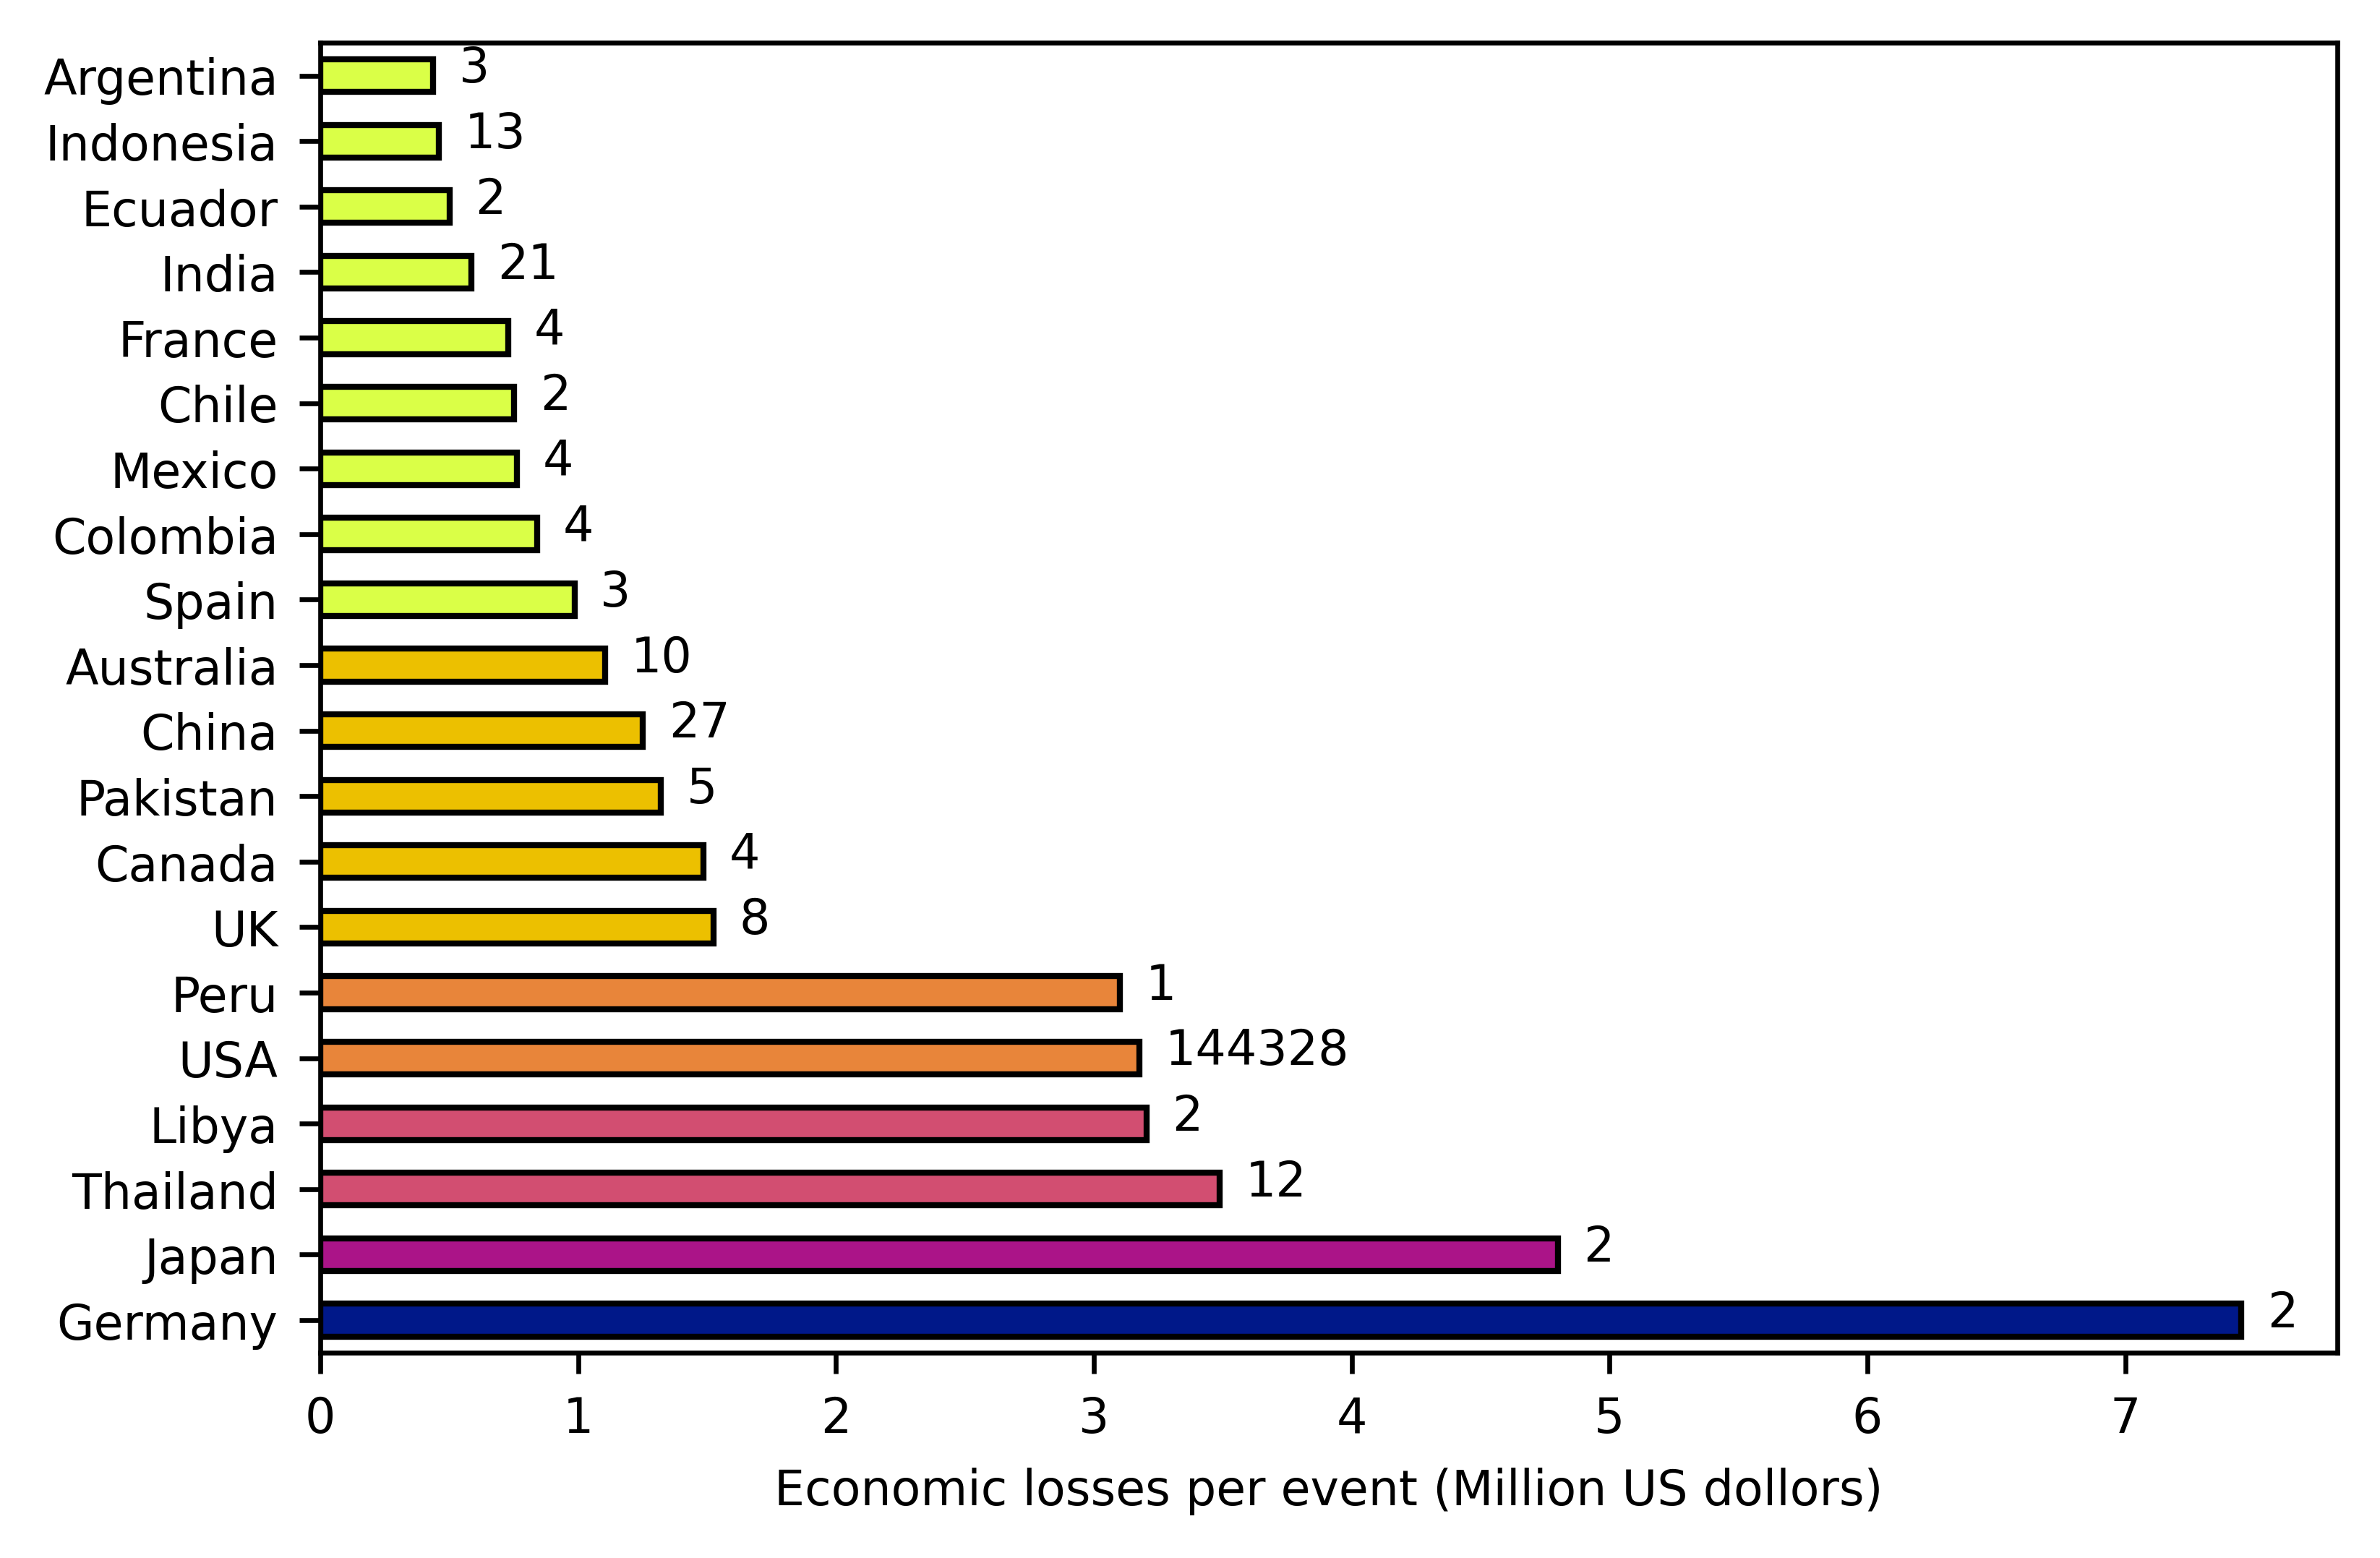

In [101]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
countries= world.sort_values('losses', ascending=False)[:20]
world.sort_values('losses', ascending=False).losses[:20].plot(kind='barh', xlabel='', ax=ax,
                        color=cmap(countries.losses/countries.losses.max()),
                                                              edgecolor='k',alpha=1)
ax.set_xlabel('Economic losses per event (Million US dollors)')



countries.index= countries.index.str.replace('United States of America', 'USA')
countries.index= countries.index.str.replace('United Kingdom', 'UK')
# ax.set_yticks()
ax.set_yticklabels(countries.index)
for i in range(len(countries)):
    ax.text(countries.iloc[i,5]+.1, i-0.1, int(countries.iloc[i,-1]))
    

In [102]:
fig.savefig('src/counts_countries.png',dpi=300, )

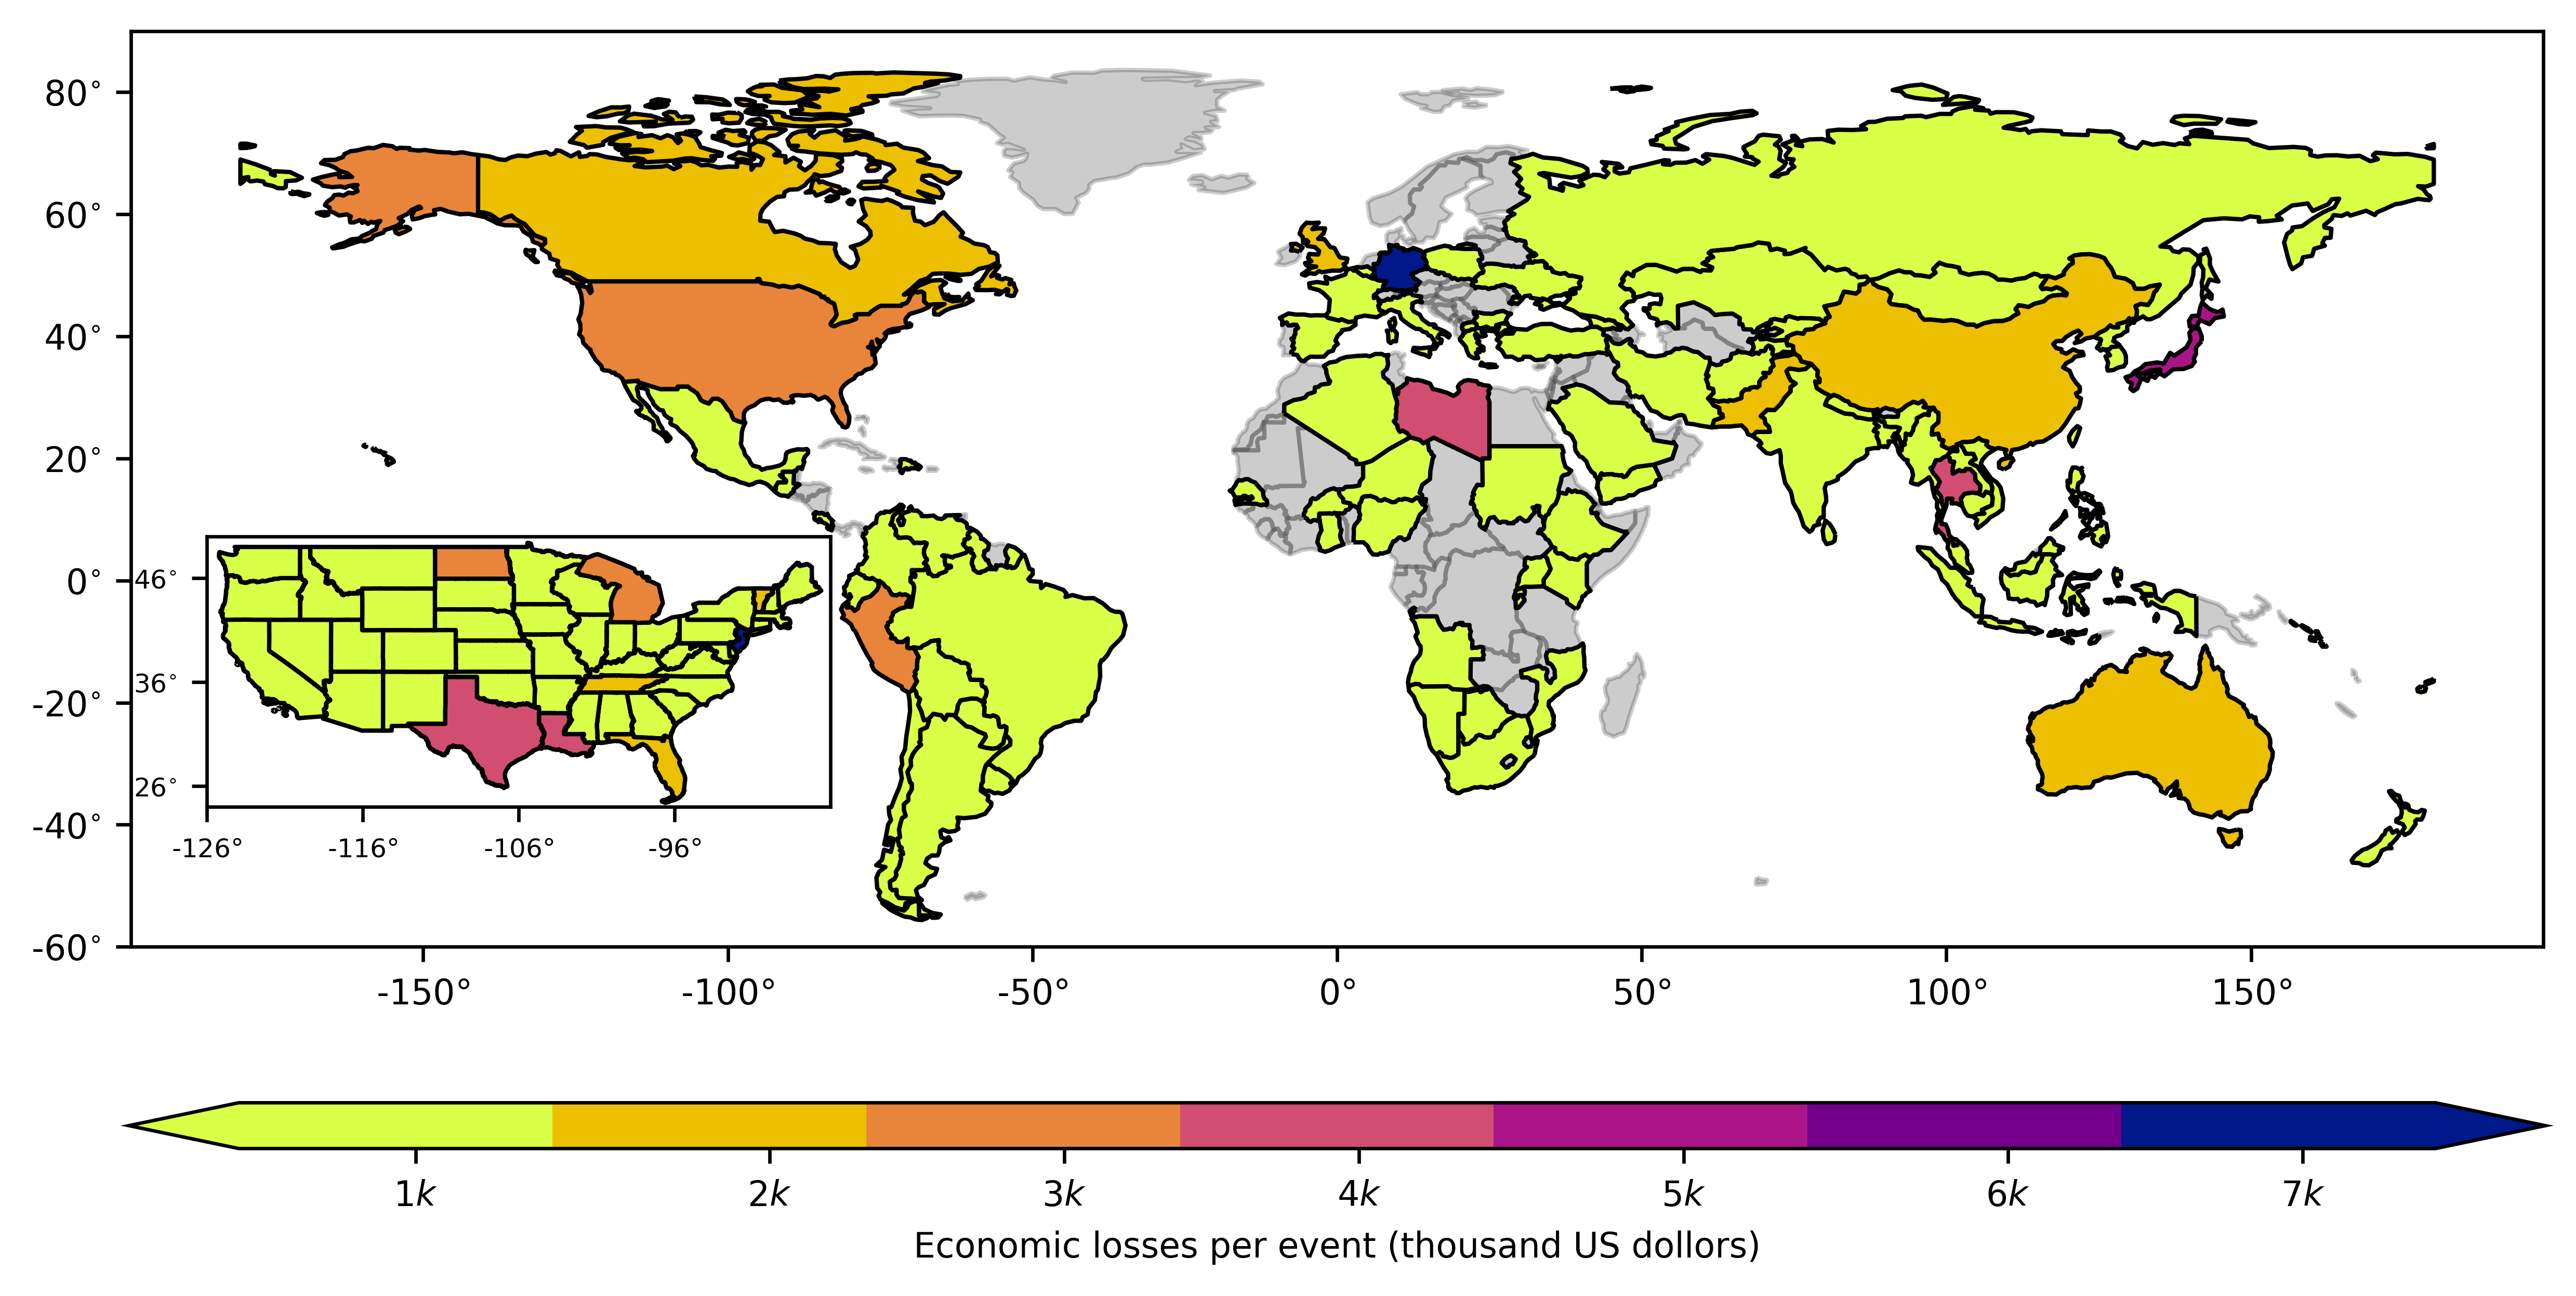

In [80]:
colors= ("#001889","#72008D","#AB1488","#D24E71","#E8853A","#ECC000","#DAFF47")[::-1]
cmap= ListedColormap(colors)
fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
world.plot(ax=ax,alpha=0.2, edgecolor='black')
view= world.plot(column='losses',ax=ax, cmap=cmap, legend=True, cax=cax, edgecolor='black',
           legend_kwds={'label': "Economic losses per event (thousand US dollors)",
                        'orientation': "horizontal",
                       "ticks": [0.6,1.8,2.8,3.8,4.9,6,7],
                       "extend": 'both'},
                        )

# cax.set_xticks(np.arange(1,8))
cax.set_xticklabels(['$%dk$'%i for i in range(1,8)]);
ax.set_xticks(np.arange(-150,200,50))
ax.set_xticklabels(['%d$\degree$'%i for i in range(-150,200,50)])
ax.set_yticks(np.arange(-60,100,20))
ax.set_yticklabels(['%d$^{\circ}$'%i for i in range(-60,100,20)])
ax.set_ylim([-60,90]);

ax2=fig.add_axes([0.15,0.35,0.2,0.2])
US_states.plot(column='losses', cmap=cmap,ax=ax2, edgecolor='black')
ax2.set_xlim([-126.0,-66.0])
ax2.set_ylim([24,50])
# ax2.axis('off');
ax2.set_xticks(np.arange(-126.0,-66.0,15))
ax2.set_xticklabels(['%d$\degree$'%i for i in range(-126,-66,10)], fontsize=6)
ax2.set_yticks(np.arange(26,50,10))
ax2.set_yticklabels(['%d$^{\circ}$'%i for i in range(26,50,10)], fontsize=6);   

In [81]:
fig.savefig('src/losses_glob.png', dpi=300)

In [57]:
df.SOURCE.unique()

array([nan, 'OFFICIAL NWS OBS.', 'NEWSPAPER', 'LAW ENFORCEMENT',
       'PARK/FOREST SERVICE', 'EMERGENCY MANAGER', 'UNKNOWN',
       'OTHER FEDERAL AGENCY', 'DEPT OF HIGHWAYS', 'GENERAL PUBLIC',
       'TRAINED SPOTTER', 'NWS EMPLOYEE(OFF DUTY)',
       'AWOS,ASOS,MESONET,ETC', 'AMATEUR RADIO', 'BROADCAST MEDIA',
       'NWS STORM SURVEY', 'GOVT OFFICIAL', 'POST OFFICE',
       'FIRE DEPT/RESCUE SQUAD', 'AIRPLANE PILOT',
       'METEOROLOGIST(NON NWS)', 'UTILITY COMPANY', 'INSURANCE COMPANY',
       'STORM CHASER', 'MARINER', 'COASTAL OBSERVING STATION', 'BUOY',
       'COOP STATION', 'C-MAN Station', 'Law Enforcement',
       'Broadcast Media', 'Newspaper', 'Other Federal Agency',
       'Trained Spotter', 'Emergency Manager',
       'Official NWS Observations', 'Fire Department/Rescue',
       'Amateur Radio', 'COOP Observer', 'County Official', 'Mesonet',
       'Department of Highways', 'Public', 'NWS Storm Survey',
       'Utility Company', 'NWS Employee', 'Unknown', 'ASOS',
    

In [68]:
df[df.CAUSE=='heavy rain,Storm'].head()

DATE_BEGIN  DATE_END  DURATION         LON      LAT     COUNTRY  \
ID                                                                         
147739  2.00901e+07  20090113      10.0  143.136000 -17.1271   Australia   
147751  2.00901e+07  20090227      32.0    0.706865  29.6139     Algeria   
148042   2.0101e+07  20101012      11.0   91.035000  24.2100  Bangladesh   
148074  2.01012e+07  20110204      41.0  147.631000 -24.7747   Australia   
148160  2.01108e+07  20120109     157.0  102.822000  17.0382    Thailand   

       STATE LOCATION       AREA  FATALITY  ...  SOURCE_DB  SOURCE_ID  \
ID                                          ...                         
147739   NaN      NaN  776847.75      28.0  ...        DFO       3428   
147751   NaN      NaN  132806.58       0.0  ...        DFO       3440   
148042   NaN      NaN   29265.76      15.0  ...        DFO       3732   
148074   NaN      NaN  911256.21      35.0  ...        DFO       3764   
148160   NaN      NaN   96785.77     790.0  ...        DFO       3850   

       DESCRIPTION     slope  dem LULC DISTANT_RIVER  CONT_AREA DEPTH    year  
ID                                                                             
147739         NaN   1.01848  151  124       11.1561    2.56122   NaN  2009.0  
147751         NaN  0.471205  355   60       4313.42        NaN   NaN  2009.0  
148042         NaN    1.3761    5   40      0.213071        NaN  7.77  2010.0  
148074         NaN   14.8484  967  112       9.75663    2.56277   NaN  2010.0  
148160         NaN   1.54544  211   40      0.827392  0.0617327   NaN  2011.0  

[5 rows x 24 columns]

In [75]:
causes_pre= df.CAUSE.str.split(',').tolist()

In [129]:
causes= []
for cause in causes_pre:
    if isinstance(cause, list):
        for _cause in cause:
            causes.append(_cause)
    else:
        if isinstance(cause, str):
            causes.append(cause)

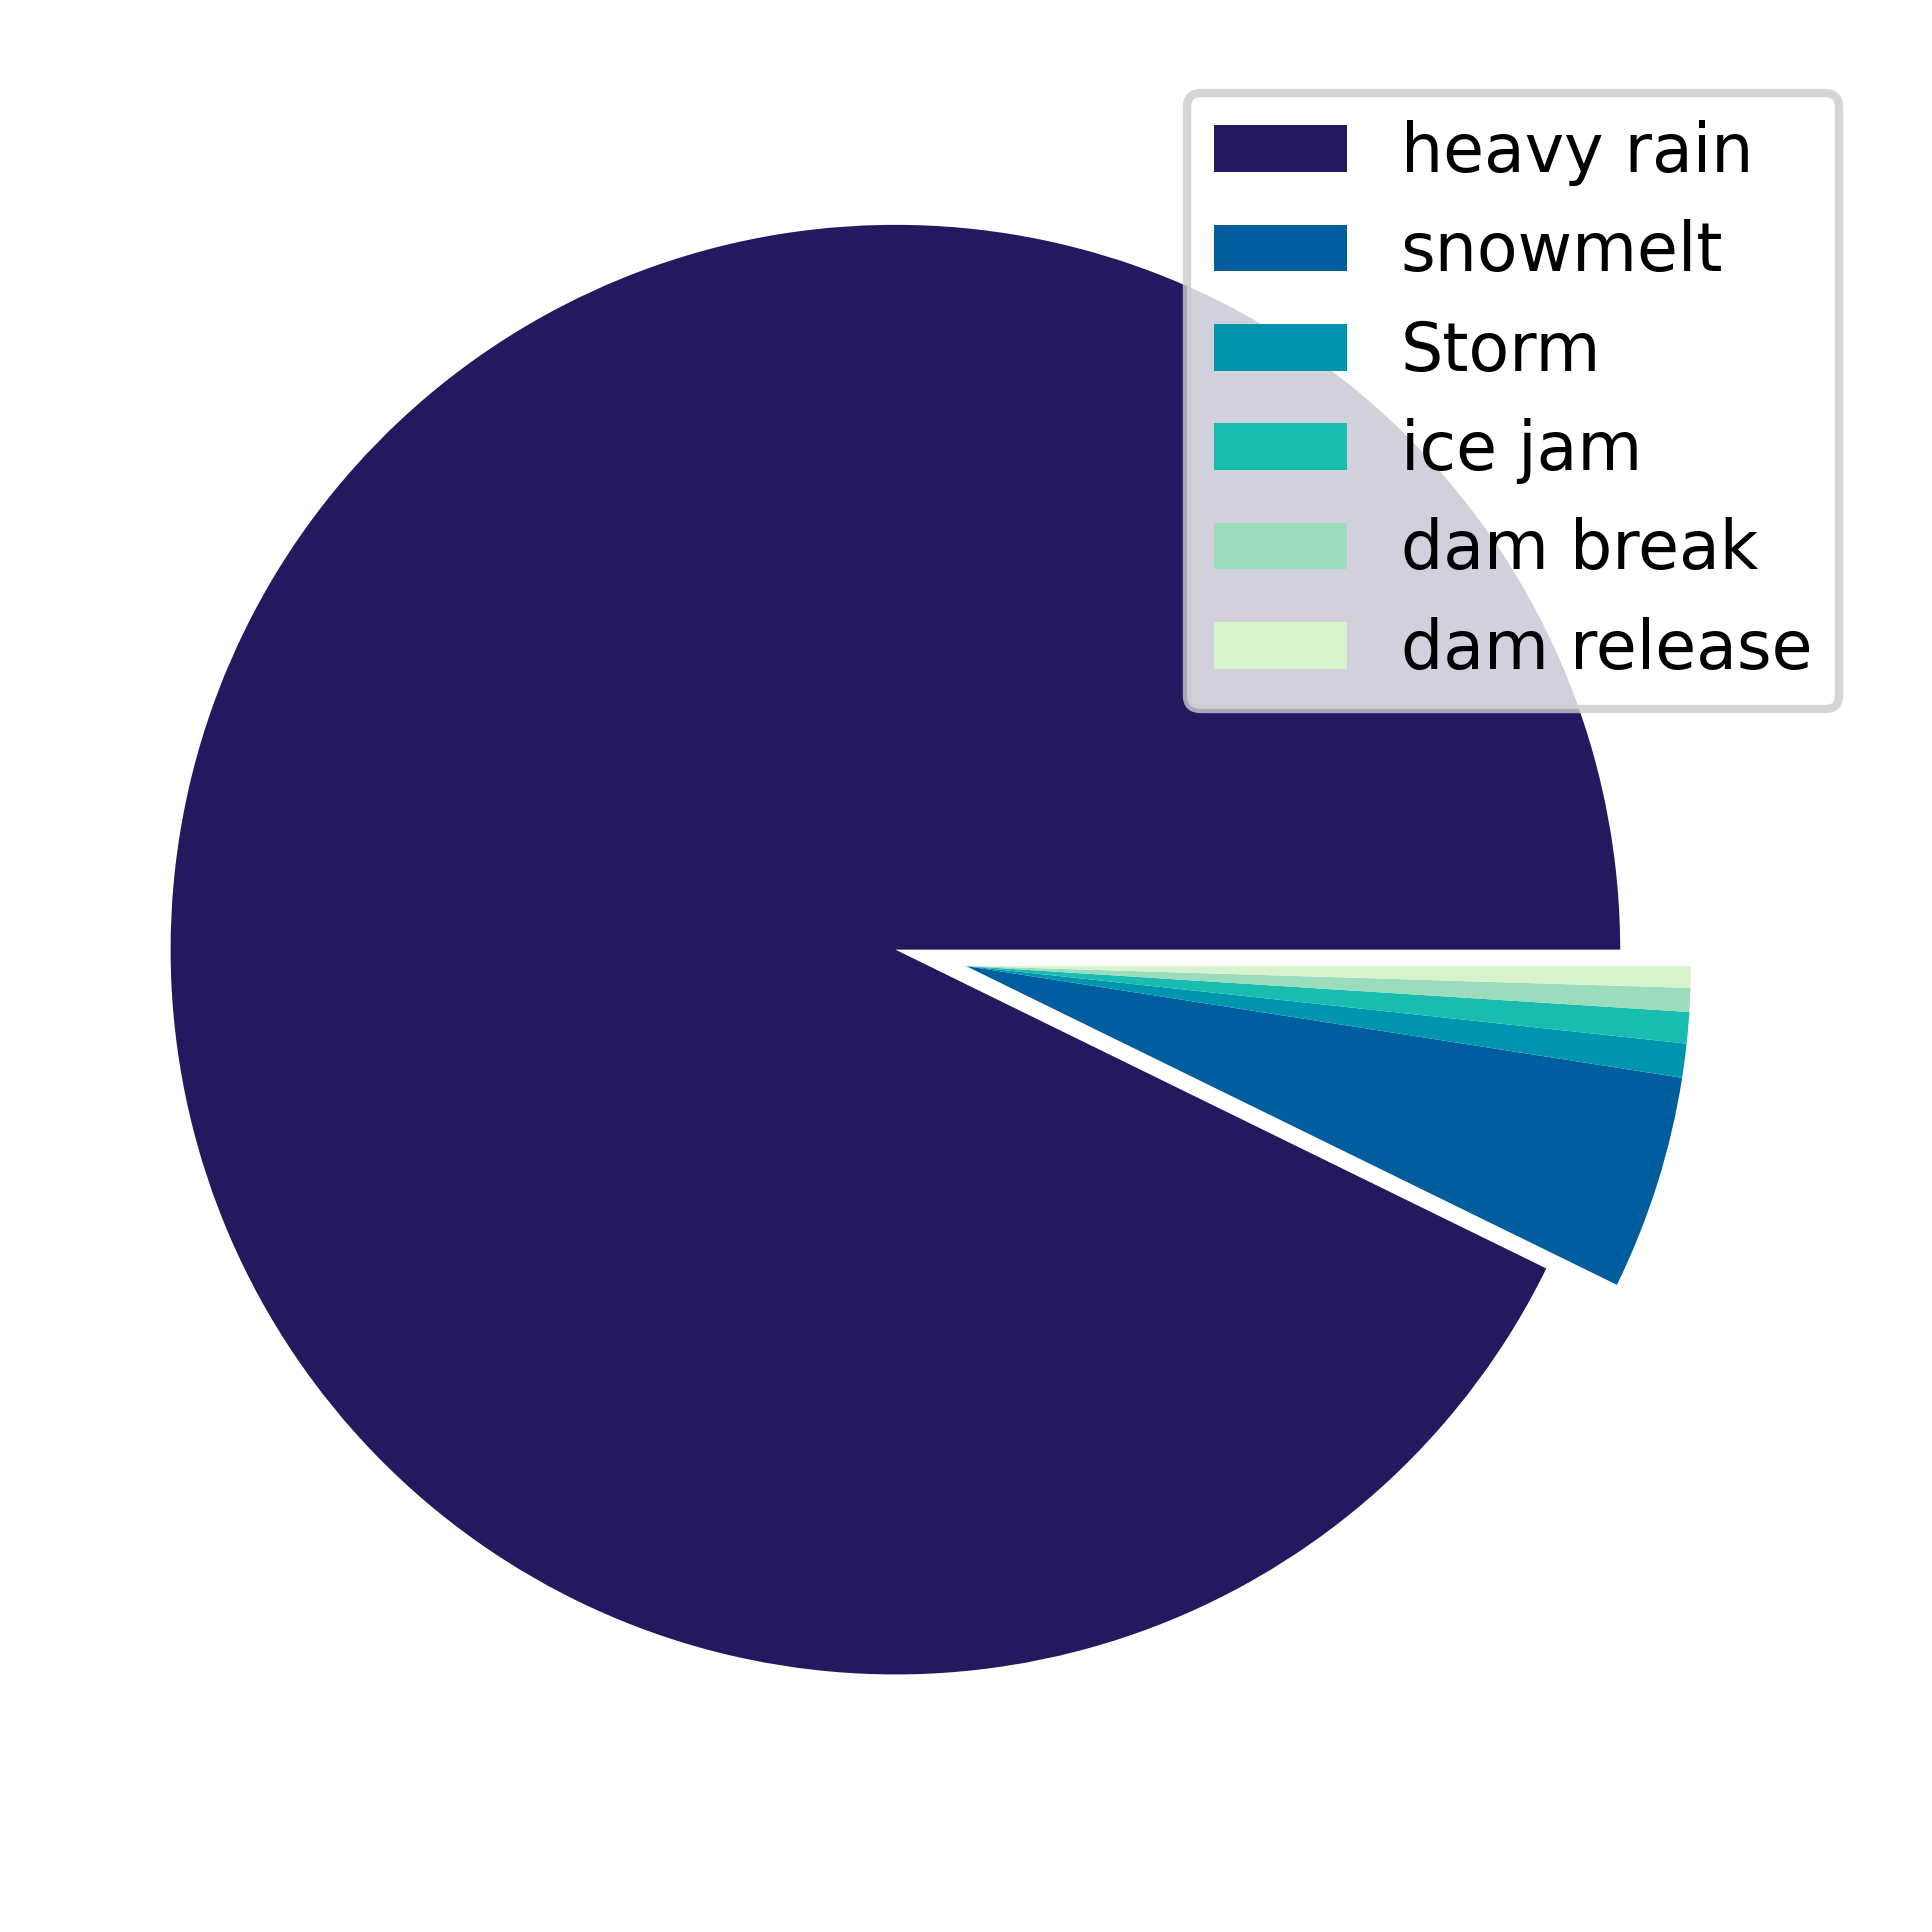

In [130]:
colors = ("#26185F","#005D9E","#0095AF","#18BDB0","#9ADCBB","#D7F4CF")
fig=plt.figure(figsize=(4,4))
ax= fig.add_subplot(111)
causes= pd.Series(causes).value_counts()
patches,_=ax.pie(causes.values/causes.values.sum(), labels=None, explode=[0.1,0,0,0,0,0],shadow=False,
              colors=colors)
ax.legend(patches,causes.index)

# Feature importance

In [1]:
df= pd.read_csv('merged_v0.45.csv', index_col='ID')

/home/allen/Documents/Programs/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,2,8,13,14,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.COUNTRY.unique()

array(['United States of America', 'Algeria', 'Brazil', 'Philippines',
       'Indonesia', 'Mozambique', nan, 'New Zealand', 'Bolivia', 'China',
       'Puerto Rico', 'Argentina', 'Bangladesh', 'India', 'Germany',
       'Chad', 'Sudan', 'Nepal', 'Austria', 'Ethiopia', 'Japan',
       'Vietnam', 'Sweden', 'Haiti', 'Nigeria', 'Benin', 'Thailand',
       'Jamaica', 'Venezuela', 'Iran', 'Chile', 'Cuba', 'Colombia',
       'Canada', 'Uruguay', 'Mexico', 'Tunisia', 'Madagascar', 'Peru',
       'Georgia', 'Ecuador', 'Afghanistan', 'Serbia', 'Australia',
       'Poland', 'Dominican Rep.', 'Italy', 'South Korea', 'South Africa',
       'Spain', 'Egypt', 'Taiwan', 'Costa Rica', 'Botswana', 'Turkey',
       'Czechia', 'Kenya', 'Uganda', 'Sri Lanka', 'Ukraine', 'Russia',
       'Pakistan', 'Nicaragua', 'Burkina Faso', 'Niger', 'El Salvador',
       'Senegal', 'France', 'Ghana', 'Guatemala', 'Gabon',
       'United Kingdom', 'Portugal', 'Bosnia and Herz.', 'Zambia',
       'Yemen', 'Fiji', 'Namibi

In [178]:
array= df[(~pd.isna(df.DISTANT_RIVER)) & (~pd.isna(df.slope)) & (~pd.isna(df.dem)) & (~pd.isna(df.LULC)) &
   (~pd.isna(df.CONT_AREA)) & (~pd.isna(df.DEPTH))][['dem','slope','LULC','DISTANT_RIVER','CONT_AREA','DEPTH']].values

In [125]:
legend= pd.read_csv('LULC_legend.txt', header=None, delimiter='\t', index_col=0)

In [126]:
fig=plt.figure(figsize=(12,18))
ax=fig.add_subplot(321)
feature= df.dem.values
feature= feature[~np.isnan(feature)]
feature_group= np.array([0,50,100,200,500,1000,1500,2000,3000])
colors=cm.get_cmap('terrain', 9)(np.linspace(0,1,9))
counts= [len(feature[(feature>=feature_group[i]) & (feature<feature_group[i+1])]) for i in range(len(feature_group)-1)]
counts.append(len(feature[feature>feature_group[-1]]))
ax.bar(['0-50','50-100','100-200','200-500','500-1000','1000-1500','1500-2000',
        '2000-3000','>3000'], np.array(counts)/1000., edgecolor='k', color=colors)
ax.set_xlabel('DEM (m)', fontsize=14)
ax.set_ylabel('Events (k)', fontsize=14)
ax.set_title('(a)',loc='left',pad=1, fontsize=16)
ax.set_xticklabels(['0-50','50-100','100-200','200-500','500-1000','1000-1500','1500-2000',
        '2000-3000','>3000'],rotation=15)

ax=fig.add_subplot(322)
feature= df.slope.values
feature= feature[~np.isnan(feature)]
feature_group= np.array([0,1,2,3,4,5,8,10,20])
counts= [len(feature[(feature>=feature_group[i]) & (feature<feature_group[i+1])]) for i in range(len(feature_group)-1)]
counts.append(len(feature[feature>feature_group[-1]]))
colors=cm.get_cmap('Greys', 9)(np.linspace(0,1,9))[::-1]
ax.bar(['0-1','1-2','2-3','3-4','4-5','5-8','8-10','10-20','>20'], np.array(counts)/1000., edgecolor='k', color=colors)
ax.set_xlabel('Slope (rad)', fontsize=14)
ax.set_ylabel('Events (k)', fontsize=14)
ax.set_title('(b)',loc='left',pad=1, fontsize=16)


ax= fig.add_subplot(323)
feature= df.DISTANT_RIVER.values
feature= feature[~np.isnan(feature)]
feature_group= [0,1,2,5,10,20,50,100]
colors=cm.get_cmap('cool', 8)(np.linspace(0,1,8))
counts= [len(feature[(feature>=feature_group[i]) & (feature<feature_group[i+1])]) for i in range(len(feature_group)-1)]
counts.append(len(feature[feature>feature_group[-1]]))
ax.bar(['0-1','1-2','2-5','5-10','10-20','20-50','50-100','>100'], np.array(counts)/1000., edgecolor='k',
      color=colors)
ax.set_xlabel('Distance to major river network (km)', fontsize=14)
ax.set_ylabel('Events (k)', fontsize=14);
ax.set_title('(c)',loc='left',pad=1, fontsize=16)

ax= fig.add_subplot(324)
feature= df.CONT_AREA.values
feature= feature[~np.isnan(feature)]
feature_group= [0,1,2,5,10,20,50,100]
counts= [len(feature[(feature>=feature_group[i]) & (feature<feature_group[i+1])]) for i in range(len(feature_group)-1)]
counts.append(len(feature[feature>feature_group[-1]]))
colors=cm.get_cmap('Blues', 9)(np.linspace(0,1,8))
ax.bar(['0-1','1-2','1-5','5-10','10-20','20-50','50-100','>100'], np.array(counts)/1000., edgecolor='k',
      color=colors)
ax.set_xlabel('Contributing area (sqkm)', fontsize=14)
ax.set_ylabel('Events (k)', fontsize=14);
ax.set_title('(d)',loc='left',pad=1, fontsize=16)

ax= fig.add_subplot(325)
feature= df.LULC.values
feature= feature[~np.isnan(feature)]
# feature_group= [0,1,5,10,20,50,100]
counts= np.array([len(feature[feature==val]) for val in np.unique(feature)])
codes= np.unique(feature).astype(int)[np.argsort(counts)[::-1]]
colors= ['#'+color for color in legend.loc[codes,1]]
# counts= sorted(counts)[::-1]
ax.bar(codes.astype(str),np.sort(counts)[::-1]/1000., edgecolor='k', color=colors)
ax.set_xlabel('Land use land cover', fontsize=14)
ax.set_xticks([])
ax.set_ylabel('Events (k)', fontsize=14)
# ax.set_xticklabels(np.unique(feature).astype(int).astype(str)[np.argsort(counts)[::-1]], rotation=45)
from matplotlib.patches import Patch
legend_elements =  [Patch(facecolor='#'+legend.loc[code,1],
                         label=legend.loc[code,2]) for code in codes]
ax.legend(handles=legend_elements, frameon=False);
ax.set_title('(e)',loc='left',pad=1, fontsize=16)

ax= fig.add_subplot(326)
feature= df.DEPTH.values
feature= feature[~np.isnan(feature)]
feature_group= np.array([0,0.1,0.5,1,2,5,10,15,20])
colors=cm.get_cmap('ocean', 9)(np.linspace(0,1,9))[::-1]
counts= [len(feature[(feature>=feature_group[i]) & (feature<feature_group[i+1])]) for i in range(len(feature_group)-1)]
counts.append(len(feature[feature>feature_group[-1]]))
ax.bar(['0-0.1','0.1-0.5','0.5-1','1-2','2-5','5-10','10-15','15-20','>20'], np.array(counts)/1000.,
       edgecolor='k', color=colors)
ax.set_xlabel('500-yr flood depth (m)', fontsize=14)
ax.set_ylabel('Events (k)', fontsize=14)
ax.set_title('(f)',loc='left',pad=1, fontsize=16);
# ax.set_xticklabels(np.unique(feature).astype(int).astype(str)[np.argsort(counts)[::-1]], rotation=45);

In [127]:
fig.savefig('src/features.png', dpi=300)